In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
import pandas as pd
from contextlib import nullcontext
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import random
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
import lpips



In [ ]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# hmi.sharp_cea_720s.1449.20120305_170000_TAI.magnetogram.jpg

In [ ]:
# ==========================================
# 1. CONFIGURATION
# ==========================================
HP = {
    # Data Paths
    "METADATA_PATH": "/content/drive/MyDrive/DeepLearning/complete_hourly_dataset_lon_-90_to_90_cleaned.csv",
    "ROOT_DIR": "/content/drive/MyDrive/DeepLearning/preprocessed_hourly_all/",
    "SAVE_DIR": "/content/drive/MyDrive/DeepLearning/results/solar_synthesis_1",

    # VQ-GAN Hyperparams
    "IMG_SIZE": 256,
    "Z_DIM": 64,            # Latent channel dimension
    "N_CODES": 256,         # Codebook size (vocab size)
    "SOS_TOKEN" : 256,
    "COMMIT_BETA": 0.25,    # Commitment loss weight
    "LR_G": 4.5e-6,         # Lower LR for stability
    "LR_D": 4.5e-6,
    "VQGAN_EPOCHS": 50,     # Train VQGAN first

    # Transformer Hyperparams
    "TRANSFORMER_LAYERS": 12,
    "TRANSFORMER_HEADS": 8,
    "TRANSFORMER_EMBED_DIM": 512,
    "TRANSFORMER_DROPOUT": 0.1,
    "TRANSFORMER_EPOCHS": 50, # Train Transformer after VQGAN
    "LR_TRANS": 1e-4,

    # System
    "BATCH_SIZE": 256,        # Adjust based on VRAM
    "DEVICE": "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
}

# os.makedirs(HP["SAVE_DIR"], exist_ok=True)
print(f"Using Device: {HP['DEVICE']}")

Using Device: cuda


In [ ]:
def collate_skip_none(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0: return None
    return torch.utils.data.dataloader.default_collate(batch)

In [ ]:
# ==========================================
# 2. DATA LOADING (User Provided Logic)
# ==========================================

class ARDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Pre-verify files to avoid runtime errors
        self.df = df.reset_index(drop=True)
        # In a real large run, you might skip the existence check for speed
        # or do it once and save the csv.

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, str(row.harpnumber), row.SHARP_FILE)

        # Robust loading
        try:
            img = Image.open(img_path).convert('L')
        except Exception as e:
            # Fallback for missing/corrupt files during training
            print(f"Error loading {img_path}: {e}")
            return None

        if self.transform:
            img = self.transform(img)

        # We don't strictly need the label for unconditional generation,
        # but returning it preserves your structure.
        label = torch.tensor(row.label, dtype=torch.long)
        return img, label

    def __len__(self):
        return len(self.df)

def get_dataloaders():
    print("Preparing Dataframes...")
    df = pd.read_csv(HP["METADATA_PATH"])
    df["harp_start"] = pd.to_datetime(df["harp_start"])

    def assign_partition(row):
        m = row["harp_start"].month
        if m in [1, 2, 3]: return 1
        elif m in [4, 5, 6]: return 2
        elif m in [7, 8, 9]: return 3
        else: return 4

    df["partition"] = df.apply(assign_partition, axis=1)
    harp_partition = df.groupby("harpnumber")["partition"].first()
    df["partition"] = df["harpnumber"].map(harp_partition)

    train_df = df[df["partition"].isin([1, 2])]
    val_df   = df[df["partition"] == 3]
    test_df  = df[df["partition"] == 4]

    # Balancing Logic
    train_nf = train_df[train_df["label"] == 0]
    train_fl = train_df[train_df["label"] == 1]
    n_fl = len(train_fl)

    if n_fl > 0:
        train_nf_bal = train_nf.sample(n=n_fl, random_state=42)
        train_balanced = pd.concat([train_nf_bal, train_fl]).sample(frac=1, random_state=42).reset_index(drop=True)
    else:
        train_balanced = train_nf # Fallback if no flares

    print(f"Train Size: {len(train_balanced)} | Val Size: {len(val_df)} | Test Size: {len(test_df)}")

    transform = transforms.Compose([
        transforms.Resize((HP["IMG_SIZE"], HP["IMG_SIZE"])), # Ensure size matches model
        transforms.ToTensor(),
        # Normalize strictly to [-1, 1] for VQGAN (using Tanh) implies input should be roughly centered
        # But here we stick to [0,1] input and handle it in model or via normalize
        # Ideally VQGAN uses [-1, 1]. Let's normalize grayscale 0.5 mean/std
        transforms.Normalize((0.5,), (0.5,))
    ])



    train_ds = ARDataset(train_balanced, HP["ROOT_DIR"], transform=transform)
    val_ds   = ARDataset(val_df, HP["ROOT_DIR"], transform=transform)
    test_ds = ARDataset(test_df, HP["ROOT_DIR"], transform=transform)

    train_loader = DataLoader(train_ds, batch_size=HP["BATCH_SIZE"], shuffle=True,
                              num_workers=2, collate_fn=collate_skip_none, drop_last=True)
    val_loader   = DataLoader(val_ds, batch_size=HP["BATCH_SIZE"], shuffle=False,
                              num_workers=2, collate_fn=collate_skip_none, drop_last=True)
    test_loader = DataLoader(test_ds, batch_size=HP["BATCH_SIZE"], shuffle=False, )


    return train_loader, val_loader, test_loader

In [ ]:
# class ARDataset(Dataset):
#     def __init__(self, df, root_dir, transform=None, cache_in_ram=False):
#         """
#         Args:
#             cache_in_ram (bool): If True, loads all images into memory on init.
#                                  Use this ONLY for the training set (8k images).
#         """
#         self.root_dir = root_dir
#         self.transform = transform
#         self.df = df.reset_index(drop=True)
#         self.cache_in_ram = cache_in_ram
#         self.data_cache = []

#         if self.cache_in_ram:
#             print(f"Loading {len(self.df)} images into RAM to speed up A100 training...")
#             for idx in tqdm(range(len(self.df)), desc="Caching Data"):
#                 row = self.df.iloc[idx]
#                 img_path = os.path.join(self.root_dir, str(row.harpnumber), row.SHARP_FILE)
#                 try:
#                     # Load and convert immediately
#                     with Image.open(img_path) as img:
#                         img = img.convert('L')
#                         # Make a copy to close file handle strictly
#                         img_copy = img.copy()
#                         self.data_cache.append(img_copy)
#                 except Exception as e:
#                     # print(f"Error caching {img_path}") # Optional: uncomment to debug
#                     self.data_cache.append(None)
#             print("Caching complete.")

#     def __getitem__(self, idx):
#         # 1. Try fetching from RAM Cache
#         if self.cache_in_ram:
#             img = self.data_cache[idx]
#         else:
#             # 2. Fallback to Disk Load (for Validation/Test sets)
#             row = self.df.iloc[idx]
#             img_path = os.path.join(self.root_dir, str(row.harpnumber), row.SHARP_FILE)
#             try:
#                 img = Image.open(img_path).convert('L')
#             except Exception:
#                 img = None

#         # Handle Missing/Corrupt Files
#         if img is None:
#             # Return a black image or handle in collate_fn
#             # Returning a tensor ensures the pipeline doesn't crash,
#             # though collate_skip_none is better if you have it.
#             return torch.zeros((1, HP["IMG_SIZE"], HP["IMG_SIZE"])), torch.tensor(0)

#         if self.transform:
#             img = self.transform(img)

#         # Label lookup
#         row = self.df.iloc[idx]
#         label = torch.tensor(row.label, dtype=torch.long)
#         return img, label

#     def __len__(self):
#         return len(self.df)

# # Update the loader function to use the caching flag
# def get_dataloaders():
#     print("Preparing Dataframes...")
#     df = pd.read_csv(HP["METADATA_PATH"])
#     df["harp_start"] = pd.to_datetime(df["harp_start"])

#     # ... (Keep your existing partitioning logic here) ...
#     def assign_partition(row):
#         m = row["harp_start"].month
#         if m in [1, 2, 3]: return 1
#         elif m in [4, 5, 6]: return 2
#         elif m in [7, 8, 9]: return 3
#         else: return 4

#     df["partition"] = df.apply(assign_partition, axis=1)
#     harp_partition = df.groupby("harpnumber")["partition"].first()
#     df["partition"] = df["harpnumber"].map(harp_partition)

#     train_df = df[df["partition"].isin([1, 2])]
#     val_df   = df[df["partition"] == 3]


#     # Balancing logic
#     train_nf = train_df[train_df["label"] == 0]
#     train_fl = train_df[train_df["label"] == 1]
#     n_fl = len(train_fl)

#     if n_fl > 0:
#         train_nf_bal = train_nf.sample(n=n_fl, random_state=42)
#         train_balanced = pd.concat([train_nf_bal, train_fl]).sample(frac=1, random_state=42).reset_index(drop=True)
#     else:
#         train_balanced = train_nf

#     print(f"Train Size: {len(train_balanced)} | Val Size: {len(val_df)}")

#     transform = transforms.Compose([
#         transforms.Resize((HP["IMG_SIZE"], HP["IMG_SIZE"])),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5,), (0.5,))
#     ])

#     # --- ENABLE CACHE FOR TRAIN ONLY ---
#     train_ds = ARDataset(train_balanced, HP["ROOT_DIR"], transform=transform, cache_in_ram=True)

#     # --- DISABLE CACHE FOR VAL (Too big for RAM usually) ---
#     val_ds   = ARDataset(val_df, HP["ROOT_DIR"], transform=transform, cache_in_ram=False)

#     # Num workers can be 0 now for Train (since it's in RAM)
#     # But for Val, we keep it at 2 to help with disk reading
#     train_loader = DataLoader(train_ds, batch_size=HP["BATCH_SIZE"], shuffle=True,
#                               num_workers=0, collate_fn=collate_skip_none, drop_last=True)
#     val_loader   = DataLoader(val_ds, batch_size=HP["BATCH_SIZE"], shuffle=False,
#                               num_workers=2, collate_fn=collate_skip_none, drop_last=True)

#     return train_loader, val_loader

In [ ]:
# ==========================================
# 3. VQ-GAN MODEL ARCHITECTURE
# ==========================================

class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, channels, 3, padding=1)
        )
    def forward(self, x):
        return x + self.block(x)

class Encoder(nn.Module):
    def __init__(self, in_ch=1, z_channels=64):
        super().__init__()
        # 256x256 -> 16x16 (Downsample factor 16 = 2^4)
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 64, 4, 2, 1),   # 256 -> 128
            nn.SiLU(),
            ResBlock(64),
            nn.Conv2d(64, 128, 4, 2, 1),     # 128 -> 64
            nn.SiLU(),
            ResBlock(128),
            nn.Conv2d(128, 128, 4, 2, 1),    # 64 -> 32
            nn.SiLU(),
            ResBlock(128),
            nn.Conv2d(128, z_channels, 4, 2, 1), # 32 -> 16
            ResBlock(z_channels),
            nn.Conv2d(z_channels, z_channels, 3, 1, 1) # Final polish
        )
    def forward(self, x):
        return self.enc(x)

class Decoder(nn.Module):
    def __init__(self, out_ch=1, z_channels=64):
        super().__init__()
        # 16x16 -> 256x256
        self.dec = nn.Sequential(
            nn.Conv2d(z_channels, z_channels, 3, 1, 1),
            ResBlock(z_channels),

            nn.ConvTranspose2d(z_channels, 128, 4, 2, 1), # 16 -> 32
            nn.SiLU(),
            ResBlock(128),

            nn.ConvTranspose2d(128, 128, 4, 2, 1), # 32 -> 64
            nn.SiLU(),
            ResBlock(128),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 64 -> 128
            nn.SiLU(),
            ResBlock(64),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 128 -> 256
            nn.SiLU(),
            nn.Conv2d(32, out_ch, 3, 1, 1),
            nn.Tanh() # Output in [-1, 1]
        )
    def forward(self, z):
        return self.dec(z)

class VectorQuantizer(nn.Module):
    def __init__(self, n_codes, code_dim, beta=0.25):
        super().__init__()
        self.n_codes = n_codes
        self.code_dim = code_dim
        self.beta = beta
        self.embedding = nn.Embedding(n_codes, code_dim)
        self.embedding.weight.data.uniform_(-1.0 / n_codes, 1.0 / n_codes)

    def forward(self, z):
        # z: [B, C, H, W] -> [B, H, W, C]
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.code_dim)

        # Distances
        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - \
            2 * torch.matmul(z_flattened, self.embedding.weight.t())

        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)

        # Loss
        loss = self.beta * torch.mean((z_q.detach() - z)**2) + \
               torch.mean((z_q - z.detach())**2)

        # Straight-through estimator
        z_q = z + (z_q - z).detach()
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return z_q, loss, min_encoding_indices

class VQGAN(nn.Module):
    def __init__(self, hp):
        super().__init__()
        self.encoder = Encoder(z_channels=hp["Z_DIM"])
        self.decoder = Decoder(z_channels=hp["Z_DIM"])
        self.quantizer = VectorQuantizer(hp["N_CODES"], hp["Z_DIM"], hp["COMMIT_BETA"])

    def forward(self, x):
        z = self.encoder(x)
        z_q, loss, indices = self.quantizer(z)
        rec = self.decoder(z_q)
        return rec, loss, indices

    def decode_indices(self, indices, shape=(16, 16)):
        # indices: [B, H*W] or [B*H*W]
        # shape: (H, W) of the latent grid
        z_q = self.quantizer.embedding(indices) # [B*H*W, C] or [B, Len, C]

        if len(z_q.shape) == 2: # Flattened batch
            b = z_q.shape[0] // (shape[0]*shape[1])
            z_q = z_q.view(b, shape[0], shape[1], -1)

        z_q = z_q.permute(0, 3, 1, 2).contiguous() # [B, C, H, W]
        return self.decoder(z_q)

# Discriminator for VQGAN training
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc=1, ndf=64, n_layers=3):
        super().__init__()
        sequence = [nn.Conv2d(input_nc, ndf, 4, 2, 1), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, 4, 2, 1),
                nn.BatchNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]
        sequence += [nn.Conv2d(ndf * nf_mult, 1, 4, 1, 1)]
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)



In [ ]:
# ==========================================
# 4. TRANSFORMER MODEL (GPT Style)
# ==========================================

class SelfAttention(nn.Module):
    def __init__(self, embed_dim, heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.heads = heads
        self.head_dim = embed_dim // heads

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys   = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries= nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_dim)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split embedding into self.heads pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys   = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries= query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys   = self.keys(keys)
        queries= self.queries(queries)

        # Einsum for matrix mult:
        # queries shape: (N, query_len, heads, heads_dim)
        # keys shape:    (N, key_len, heads, heads_dim)
        # energy shape:  (N, heads, query_len, key_len)
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_dim ** (1/2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        return self.fc_out(out)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads, dropout, forward_expansion):
        super().__init__()
        self.attention = SelfAttention(embed_dim, heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, forward_expansion * embed_dim),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_dim, embed_dim),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class ARTransformer(nn.Module):
    def __init__(self, hp):
        super().__init__()
        self.src_vocab_size = hp["N_CODES"]
        self.embed_dim = hp["TRANSFORMER_EMBED_DIM"]
        self.layers = hp["TRANSFORMER_LAYERS"]
        self.heads = hp["TRANSFORMER_HEADS"]
        self.device = hp["DEVICE"]
        self.dropout = hp["TRANSFORMER_DROPOUT"]

        # Sequence Length = (256 / 16)^2 = 16*16 = 256 tokens
        self.seq_length = (hp["IMG_SIZE"] // 16) ** 2

        self.word_embedding = nn.Embedding(self.src_vocab_size, self.embed_dim)
        self.position_embedding = nn.Embedding(self.seq_length, self.embed_dim)

        self.blocks = nn.ModuleList(
            [
                TransformerBlock(
                    self.embed_dim,
                    self.heads,
                    dropout=self.dropout,
                    forward_expansion=4
                )
                for _ in range(self.layers)
            ]
        )
        self.fc_out = nn.Linear(self.embed_dim, self.src_vocab_size)
        self.dropout_layer = nn.Dropout(self.dropout)

    def forward(self, x):
        # x shape: (N, seq_len)
        N, seq_len = x.shape
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        out = self.dropout_layer(self.word_embedding(x) + self.position_embedding(positions))

        # Causal Mask
        # (N, Heads, QueryLen, KeyLen)
        mask = torch.tril(torch.ones((seq_len, seq_len))).to(self.device)

        for layer in self.blocks:
            out = layer(out, out, out, mask)

        # logits: (N, seq_len, vocab_size)
        return self.fc_out(out)



In [ ]:
# ==========================================
# 5. TRAINING FUNCTIONS
# ==========================================

def train_vqgan_stage(train_loader, vqgan, disc, opt_vq, opt_disc):
    print("\n--- Starting Stage 1: VQ-GAN Training ---")
    loss_history = []

    for epoch in range(HP["VQGAN_EPOCHS"]):
        vqgan.train()
        loop = tqdm(train_loader, leave=True)
        for i, batch in enumerate(loop):
            # Batch is [img, label] but collate might return None if empty
            if batch is None: continue

            img, _ = batch
            img = img.to(HP["DEVICE"])

            # 1. Train Discriminator
            rec, q_loss, _ = vqgan(img)

            # Hinge Loss
            d_real = disc(img)
            d_fake = disc(rec.detach())
            d_loss_real = torch.mean(F.relu(1. - d_real))
            d_loss_fake = torch.mean(F.relu(1. + d_fake))
            d_loss = 0.5 * (d_loss_real + d_loss_fake)

            opt_disc.zero_grad()
            d_loss.backward()
            opt_disc.step()

            # 2. Train Generator (VQGAN)
            rec, q_loss, _ = vqgan(img)
            d_fake = disc(rec)

            # Losses
            rec_loss = F.l1_loss(rec, img)
            g_loss = -torch.mean(d_fake) # Adversarial

            # Weighted Sum: Tuned for Grayscale scientific data
            # Higher reconstruction weight to ensure accuracy
            loss_vq = rec_loss * 10.0 + q_loss + g_loss * 0.1

            opt_vq.zero_grad()
            loss_vq.backward()
            opt_vq.step()

            loop.set_description(f"Epoch {epoch+1}/{HP['VQGAN_EPOCHS']}")
            loop.set_postfix(rec=rec_loss.item(), q=q_loss.item(), d=d_loss.item())

        # Save Reconstructions occasionally
        if (epoch+1) % 5 == 0:
            with torch.no_grad():
                concat = torch.cat((img[:4], rec[:4]), dim=2)
                # Denormalize for viewing: [-1,1] -> [0,1]
                concat = (concat + 1) / 2
                save_image(concat, f"{HP['SAVE_DIR']}/vqgan_rec_ep{epoch+1}.png")
                torch.save(vqgan.state_dict(), f"{HP['SAVE_DIR']}/vqgan_latest.pt")

def train_transformer_stage(train_loader, vqgan, transformer, opt_trans):
    print("\n--- Starting Stage 2: Transformer Training ---")
    vqgan.eval() # Freeze VQGAN

    # Calculate sequence length
    seq_len = (HP["IMG_SIZE"] // 16) ** 2

    for epoch in range(HP["TRANSFORMER_EPOCHS"]):
        transformer.train()
        loop = tqdm(train_loader, leave=True)

        for i, batch in enumerate(loop):
            if batch is None: continue
            img, _ = batch
            img = img.to(HP["DEVICE"])

            with torch.no_grad():
                # Encode images to indices
                z = vqgan.encoder(img)
                _, _, indices = vqgan.quantizer(z)
                # indices shape: [B, H, W] -> Flatten to [B, SeqLen]
                indices = indices.view(img.shape[0], -1)

            # Forward pass Transformer
            # Target is the indices shifted by 1 (predict next token)
            # Standard approach: Input indices [0:-1], Target indices [1:]

            # For causal GPT, we usually feed the whole sequence and mask locally,
            # then calculate loss on shifted targets.

            logits = transformer(indices) # [B, SeqLen, Vocab]

            # Reshape for CrossEntropy
            # logits: [B*SeqLen, Vocab]
            # targets: indices [B, SeqLen]

            # We want to predict x[t] given x[0...t-1]
            # Since our Transformer implements Causal Mask, the output at pos t depends only on 0..t
            # So output at t should predict target at t.
            # In training, we simply try to reconstruct the sequence.

            loss = F.cross_entropy(logits.view(-1, HP["N_CODES"]), indices.view(-1))

            opt_trans.zero_grad()
            loss.backward()
            opt_trans.step()

            loop.set_description(f"Epoch {epoch+1}/{HP['TRANSFORMER_EPOCHS']}")
            loop.set_postfix(loss=loss.item())

        if (epoch+1) % 5 == 0:
            torch.save(transformer.state_dict(), f"{HP['SAVE_DIR']}/transformer_latest.pt")
            # Generate a sample
            generate_sample(vqgan, transformer, epoch+1)

@torch.no_grad()
def generate_sample(vqgan, transformer, epoch):
    transformer.eval()
    vqgan.eval()

    # Start with a random token or a specific <SOS> token if implemented.
    # Here we sample entirely unconditionally.
    # We generate one token at a time.

    seq_len = (HP["IMG_SIZE"] // 16) ** 2
    bs = 4

    # Start with random indices for the first token or zeros
    # Ideally, we sample the first token uniformly
    indices = torch.randint(0, HP["N_CODES"], (bs, 1)).to(HP["DEVICE"])

    print("Sampling...")
    for _ in tqdm(range(seq_len - 1)):
        # Model input cannot exceed context length, though here we build up to seq_len
        logits = transformer(indices)

        # Take the logits for the last generated token
        last_logits = logits[:, -1, :]

        # Temperature sampling
        probs = F.softmax(last_logits / 1.0, dim=-1)

        # Sample
        next_token = torch.multinomial(probs, num_samples=1)
        indices = torch.cat([indices, next_token], dim=1)

    # Decode indices
    # indices: [B, SeqLen]
    rec = vqgan.decode_indices(indices.view(-1), shape=(16, 16)) # Flatten for decoding

    rec = (rec + 1) / 2 # Denorm
    save_image(rec, f"{HP['SAVE_DIR']}/generated_sample_ep{epoch}.png")
    transformer.train()




In [ ]:
# ==========================================
# 6. MAIN EXECUTION
# ==========================================
train_loader, val_loader, test_loader = get_dataloaders()

Preparing Dataframes...
Train Size: 8188 | Val Size: 124679 | Test Size: 128932


In [ ]:
# # 2. Setup VQGAN
# vqgan = VQGAN(HP).to(HP["DEVICE"])
# disc = NLayerDiscriminator().to(HP["DEVICE"])

# opt_vq = torch.optim.Adam(vqgan.parameters(), lr=HP["LR_G"], betas=(0.5, 0.9))
# opt_disc = torch.optim.Adam(disc.parameters(), lr=HP["LR_D"], betas=(0.5, 0.9))

# # 3. Train VQGAN (Stage 1)
# # If you have a pretrained VQGAN, you can comment this out and load weights
# # vqgan.load_state_dict(torch.load("/content/drive/MyDrive/DeepLearning/results/solar_synthesis/vqgan_latest.pt"))
# train_vqgan_stage(train_loader, vqgan, disc, opt_vq, opt_disc)



In [ ]:
#[CELL 4] VQGAN TRAINING (WITH LOSS TRACKING)

# 1. Setup History Container
history_vq = {
    "total": [],
    "rec": [],
    "quant": [],
    "disc": []
}

vqgan = VQGAN(HP).to(HP["DEVICE"])
disc = NLayerDiscriminator().to(HP["DEVICE"])

opt_vq = torch.optim.Adam(vqgan.parameters(), lr=HP["LR_G"], betas=(0.5, 0.9))
opt_disc = torch.optim.Adam(disc.parameters(), lr=HP["LR_D"], betas=(0.5, 0.9))

print("--- Starting Stage 1: VQ-GAN Training ---")

for epoch in range(HP["VQGAN_EPOCHS"]):
    vqgan.train()
    disc.train()

    # Running totals for this epoch
    epoch_loss_total = 0
    epoch_loss_rec = 0
    epoch_loss_quant = 0
    epoch_loss_disc = 0
    count = 0

    loop = tqdm(train_loader, leave=False)
    for batch in loop:
        if batch is None: continue
        img, _ = batch
        img = img.to(HP["DEVICE"])

        # --- Train Discriminator ---
        rec, q_loss, _ = vqgan(img)
        d_real = disc(img)
        d_fake = disc(rec.detach())

        d_loss_real = torch.mean(F.relu(1. - d_real))
        d_loss_fake = torch.mean(F.relu(1. + d_fake))
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        opt_disc.zero_grad()
        d_loss.backward()
        opt_disc.step()

        # --- Train VQGAN ---
        rec, q_loss, _ = vqgan(img)
        d_fake = disc(rec)
        g_loss = -torch.mean(d_fake) # Adversarial loss

        rec_loss = F.l1_loss(rec, img)

        # Total Generator Loss
        loss_vq = rec_loss * 10.0 + q_loss + g_loss * 0.1

        opt_vq.zero_grad()
        loss_vq.backward()
        opt_vq.step()

        # --- Update Running Totals ---
        epoch_loss_total += loss_vq.item()
        epoch_loss_rec += rec_loss.item()
        epoch_loss_quant += q_loss.item()
        epoch_loss_disc += d_loss.item()
        count += 1

        loop.set_postfix(rec=rec_loss.item(), d=d_loss.item())

    # Calculate Epoch Averages
    avg_total = epoch_loss_total / count
    avg_rec = epoch_loss_rec / count
    avg_quant = epoch_loss_quant / count
    avg_disc = epoch_loss_disc / count

    # Store in History
    history_vq["total"].append(avg_total)
    history_vq["rec"].append(avg_rec)
    history_vq["quant"].append(avg_quant)
    history_vq["disc"].append(avg_disc)

    print(f"Epoch {epoch+1} | Rec: {avg_rec:.4f} | Disc: {avg_disc:.4f}")

    if (epoch+1) % 10 == 0:
        torch.save(vqgan.state_dict(), f"{HP['SAVE_DIR']}/vqgan_latest.pt")

--- Starting Stage 1: VQ-GAN Training ---


Epoch 1 | Rec: 0.1704 | Disc: 0.9971


Epoch 2 | Rec: 0.1624 | Disc: 0.8622


Epoch 3 | Rec: 0.1593 | Disc: 0.7494


Epoch 4 | Rec: 0.1599 | Disc: 0.6392


Epoch 5 | Rec: 0.1589 | Disc: 0.5810


Epoch 6 | Rec: 0.1588 | Disc: 0.5538


Epoch 7 | Rec: 0.1583 | Disc: 0.5193


Epoch 8 | Rec: 0.1562 | Disc: 0.4774


Epoch 9 | Rec: 0.1538 | Disc: 0.4438


Epoch 10 | Rec: 0.1512 | Disc: 0.3930


Epoch 11 | Rec: 0.1449 | Disc: 0.3278


Epoch 12 | Rec: 0.1389 | Disc: 0.2771


Epoch 13 | Rec: 0.1332 | Disc: 0.2526


Epoch 14 | Rec: 0.1271 | Disc: 0.2389


Epoch 15 | Rec: 0.1213 | Disc: 0.2078


Epoch 16 | Rec: 0.1163 | Disc: 0.1868


Epoch 17 | Rec: 0.1113 | Disc: 0.1717


Epoch 18 | Rec: 0.1082 | Disc: 0.1702


Epoch 19 | Rec: 0.1066 | Disc: 0.1691


Epoch 20 | Rec: 0.1061 | Disc: 0.1794


Epoch 21 | Rec: 0.1051 | Disc: 0.1994


Epoch 22 | Rec: 0.1060 | Disc: 0.1942


Epoch 23 | Rec: 0.1067 | Disc: 0.1859


Epoch 24 | Rec: 0.1073 | Disc: 0.1831


Epoch 25 | Rec: 0.1071 | Disc: 0.1439


Epoch 26 | Rec: 0.1077 | Disc: 0.1076


Epoch 27 | Rec: 0.1071 | Disc: 0.0805


Epoch 28 | Rec: 0.1086 | Disc: 0.0878


Epoch 29 | Rec: 0.1122 | Disc: 0.0787


Epoch 30 | Rec: 0.1185 | Disc: 0.0793


Epoch 31 | Rec: 0.1204 | Disc: 0.1159


Epoch 32 | Rec: 0.1114 | Disc: 0.0708


Epoch 33 | Rec: 0.1080 | Disc: 0.0320


Epoch 34 | Rec: 0.1065 | Disc: 0.0470


Epoch 35 | Rec: 0.1040 | Disc: 0.0191


Epoch 36 | Rec: 0.1076 | Disc: 0.1759


Epoch 37 | Rec: 0.1025 | Disc: 0.0364


Epoch 38 | Rec: 0.1012 | Disc: 0.0125


Epoch 39 | Rec: 0.1043 | Disc: 0.1605


Epoch 40 | Rec: 0.1008 | Disc: 0.0210


Epoch 41 | Rec: 0.0996 | Disc: 0.0129


Epoch 42 | Rec: 0.1001 | Disc: 0.0087


Epoch 43 | Rec: 0.1056 | Disc: 0.2389


Epoch 44 | Rec: 0.1106 | Disc: 0.3320


Epoch 45 | Rec: 0.1082 | Disc: 0.2966


Epoch 46 | Rec: 0.0996 | Disc: 0.0516


Epoch 47 | Rec: 0.0993 | Disc: 0.1557


Epoch 48 | Rec: 0.1015 | Disc: 0.2228


Epoch 49 | Rec: 0.0967 | Disc: 0.1343


Epoch 50 | Rec: 0.0962 | Disc: 0.1643


In [ ]:
# # 4. Setup Transformer
# transformer = ARTransformer(HP).to(HP["DEVICE"])
# opt_trans = torch.optim.Adam(transformer.parameters(), lr=HP["LR_TRANS"])

# # 5. Train Transformer (Stage 2)
# train_transformer_stage(train_loader, vqgan, transformer, opt_trans)


--- Starting Stage 2: Transformer Training ---


Epoch 5/50: 100%|██████████| 1023/1023 [00:48<00:00, 20.97it/s, loss=4.66e-5]


Sampling...


Epoch 10/50: 100%|██████████| 1023/1023 [00:49<00:00, 20.64it/s, loss=2.73e-5]


Sampling...


Epoch 15/50: 100%|██████████| 1023/1023 [00:49<00:00, 20.73it/s, loss=4.21e-5]


Sampling...


Epoch 20/50: 100%|██████████| 1023/1023 [00:49<00:00, 20.70it/s, loss=4.71e-6]


Sampling...


Epoch 25/50: 100%|██████████| 1023/1023 [00:49<00:00, 20.67it/s, loss=4.67e-6]


Sampling...


Epoch 30/50: 100%|██████████| 1023/1023 [00:49<00:00, 20.60it/s, loss=3.83e-5]


Sampling...


Epoch 35/50: 100%|██████████| 1023/1023 [00:49<00:00, 20.62it/s, loss=1.02e-5]


Sampling...


Epoch 40/50: 100%|██████████| 1023/1023 [00:49<00:00, 20.72it/s, loss=2.56e-6]


Sampling...


Epoch 45/50: 100%|██████████| 1023/1023 [00:49<00:00, 20.78it/s, loss=1.22e-6]


Sampling...


Epoch 50/50: 100%|██████████| 1023/1023 [00:49<00:00, 20.67it/s, loss=1.85e-6]


Sampling...


100%|██████████| 255/255 [00:02<00:00, 99.74it/s]


In [ ]:
# TRANSFORMER TRAINING (WITH LOSS TRACKING)

history_trans = []

# Ensure vocab size includes SOS token
transformer = ARTransformer({**HP, "N_CODES": HP["N_CODES"] + 1}).to(HP["DEVICE"])
opt_trans = torch.optim.Adam(transformer.parameters(), lr=HP["LR_TRANS"])

vqgan.eval()

print("--- Starting Stage 2: Transformer Training ---")
for epoch in range(HP["TRANSFORMER_EPOCHS"]):
    transformer.train()
    epoch_loss = 0
    count = 0

    loop = tqdm(train_loader, leave=False)
    for batch in loop:
        if batch is None: continue
        img, _ = batch
        img = img.to(HP["DEVICE"])

        with torch.no_grad():
            z = vqgan.encoder(img)
            _, _, indices = vqgan.quantizer(z)
            indices = indices.view(img.shape[0], -1)

        # Shifted Inputs/Targets logic
        batch_size, seq_len = indices.shape
        sos_tokens = torch.full((batch_size, 1), HP["SOS_TOKEN"], device=HP["DEVICE"])

        inp = torch.cat([sos_tokens, indices[:, :-1]], dim=1)
        target = indices

        logits = transformer(inp)

        loss = F.cross_entropy(logits.reshape(-1, HP["N_CODES"] + 1), target.reshape(-1))

        opt_trans.zero_grad()
        loss.backward()
        opt_trans.step()

        epoch_loss += loss.item()
        count += 1
        loop.set_postfix(loss=loss.item())

    # Store Average Epoch Loss
    avg_loss = epoch_loss / count
    history_trans.append(avg_loss)

    print(f"Epoch {epoch+1} | Transformer Loss: {avg_loss:.4f}")

    if (epoch+1) % 10 == 0:
        torch.save(transformer.state_dict(), f"{HP['SAVE_DIR']}/transformer_latest.pt")

--- Starting Stage 2: Transformer Training ---


Epoch 1 | Transformer Loss: 2.2571


Epoch 2 | Transformer Loss: 1.4197


Epoch 3 | Transformer Loss: 1.1805


Epoch 4 | Transformer Loss: 0.9509


Epoch 5 | Transformer Loss: 0.8354


Epoch 6 | Transformer Loss: 0.7668


Epoch 7 | Transformer Loss: 0.7233


Epoch 8 | Transformer Loss: 0.6964


Epoch 9 | Transformer Loss: 0.6757


Epoch 10 | Transformer Loss: 0.6574


Epoch 11 | Transformer Loss: 0.6410


Epoch 12 | Transformer Loss: 0.6295


Epoch 13 | Transformer Loss: 0.6183


Epoch 14 | Transformer Loss: 0.6089


Epoch 15 | Transformer Loss: 0.6012


Epoch 16 | Transformer Loss: 0.5909


Epoch 17 | Transformer Loss: 0.5853


Epoch 18 | Transformer Loss: 0.5761


Epoch 19 | Transformer Loss: 0.5690


Epoch 20 | Transformer Loss: 0.5629


Epoch 21 | Transformer Loss: 0.5548


Epoch 22 | Transformer Loss: 0.5495


Epoch 23 | Transformer Loss: 0.5410


Epoch 24 | Transformer Loss: 0.5356


Epoch 25 | Transformer Loss: 0.5286


Epoch 26 | Transformer Loss: 0.5203


Epoch 27 | Transformer Loss: 0.5149


Epoch 28 | Transformer Loss: 0.5084


Epoch 29 | Transformer Loss: 0.5010


Epoch 30 | Transformer Loss: 0.4935


Epoch 31 | Transformer Loss: 0.4859


Epoch 32 | Transformer Loss: 0.4794


Epoch 33 | Transformer Loss: 0.4717


Epoch 34 | Transformer Loss: 0.4652


Epoch 35 | Transformer Loss: 0.4595


Epoch 36 | Transformer Loss: 0.4530


Epoch 37 | Transformer Loss: 0.4485


Epoch 38 | Transformer Loss: 0.4440


Epoch 39 | Transformer Loss: 0.4390


Epoch 40 | Transformer Loss: 0.4327


Epoch 41 | Transformer Loss: 0.4293


Epoch 42 | Transformer Loss: 0.4251


Epoch 43 | Transformer Loss: 0.4206


Epoch 44 | Transformer Loss: 0.4159


Epoch 45 | Transformer Loss: 0.4119


Epoch 46 | Transformer Loss: 0.4092


Epoch 47 | Transformer Loss: 0.4047


Epoch 48 | Transformer Loss: 0.4020


Epoch 49 | Transformer Loss: 0.3984


Epoch 50 | Transformer Loss: 0.3957


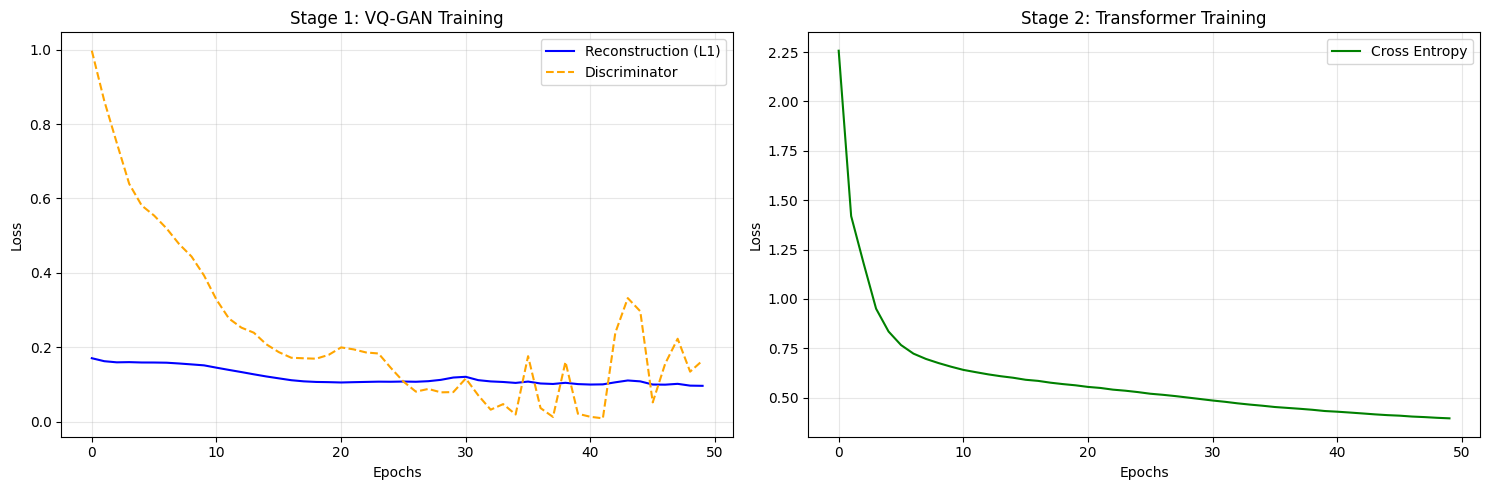

In [ ]:
# PLOT TRAINING CURVES



def plot_training_results(history_vq, history_trans):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # --- Plot 1: VQ-GAN Losses ---
    # We plot Reconstruction and Discriminator on the same graph
    # (Quantization loss is often on a different scale, so we omit it or plot separately)
    ax1.plot(history_vq['rec'], label='Reconstruction (L1)', color='blue')
    ax1.plot(history_vq['disc'], label='Discriminator', color='orange', linestyle='--')
    ax1.set_title("Stage 1: VQ-GAN Training")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- Plot 2: Transformer Loss ---
    ax2.plot(history_trans, label='Cross Entropy', color='green')
    ax2.set_title("Stage 2: Transformer Training")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run the plotter
# Note: This will only work if you have run the training cells above
if 'history_vq' in globals() and 'history_trans' in globals():
    plot_training_results(history_vq, history_trans)
else:
    print("Training history not found. Please run the training cells first.")

In [ ]:
# 1. Initialize the Model Architectures
# We must use the exact same HP configuration as training
print(f"Loading models from {HP['SAVE_DIR']}...")

# Initialize VQGAN
vqgan = VQGAN(HP).to(HP["DEVICE"])

# Initialize Transformer
# IMPORTANT: Remember we added +1 to N_CODES for the SOS token fix
transformer = ARTransformer({
    **HP,
    "N_CODES": HP["N_CODES"] + 1
}).to(HP["DEVICE"])

# 2. Load the Weights
try:
    # Load VQGAN weights
    vqgan_path = f"{HP['SAVE_DIR']}/vqgan_latest.pt"
    vqgan.load_state_dict(torch.load(vqgan_path, map_location=HP["DEVICE"]))
    print("✅ VQ-GAN loaded successfully.")

    # Load Transformer weights
    trans_path = f"{HP['SAVE_DIR']}/transformer_latest.pt"
    transformer.load_state_dict(torch.load(trans_path, map_location=HP["DEVICE"]))
    print("✅ Transformer loaded successfully.")

except FileNotFoundError as e:
    print(f"❌ Error: Could not find model files. Check path: {HP['SAVE_DIR']}")
    print(e)
except RuntimeError as e:
    print("❌ Shape Mismatch! Did you change HP parameters (like N_CODES or EMBED_DIM) since training?")
    print(e)

# 3. Set to Evaluation Mode
vqgan.eval()
transformer.eval()

print("Models ready for generation.")

Loading models from /content/drive/MyDrive/DeepLearning/results/solar_synthesis_1...
✅ VQ-GAN loaded successfully.
✅ Transformer loaded successfully.
Models ready for generation.


In [ ]:
def sample_solar_magnetograms(transformer, vqgan, n_samples=4, temperature=1.0, top_k=100):
    """
    Args:
        n_samples: Number of images to generate
        temperature: < 1.0 = less random, > 1.0 = more random
        top_k: Only sample from the top K most likely tokens (filters noise)
    """
    transformer.eval()
    vqgan.eval()

    # device
    device = HP["DEVICE"]

    # 1. Start with a random token or a specific 'SOS' token
    # (Here we just pick random starting points from the codebook)
    indices = torch.randint(0, HP["N_CODES"], (n_samples, 1)).to(device)

    seq_len = (HP["IMG_SIZE"] // 16) ** 2  # 256 tokens for 16x16 latent

    print(f"Generating {n_samples} images with Temp={temperature}, Top-K={top_k}...")

    with torch.no_grad():
        for i in tqdm(range(seq_len - 1)):
            # 2. Get predictions
            logits = transformer(indices)

            # 3. Focus only on the last step
            logits = logits[:, -1, :]

            # 4. Apply Temperature
            logits = logits / temperature

            # 5. Apply Top-K Filtering (Crucial for good quality)
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                # Mask out values smaller than the K-th largest value
                logits[logits < v[:, [-1]]] = -float('Inf')

            # 6. Sample from distribution
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # 7. Append to sequence
            indices = torch.cat([indices, next_token], dim=1)

        # 8. Decode indices to pixels using VQ-GAN
        # indices shape is [B, SeqLen]. We need to pass it to decode_indices
        rec = vqgan.decode_indices(indices.view(-1), shape=(16, 16))

        # 9. Denormalize (-1 to 1 -> 0 to 1)
        rec = (rec + 1) / 2
        rec = torch.clamp(rec, 0, 1)

    return rec.cpu()



Generating 4 images with Temp=0.8, Top-K=50...


100%|██████████| 255/255 [00:03<00:00, 66.83it/s]


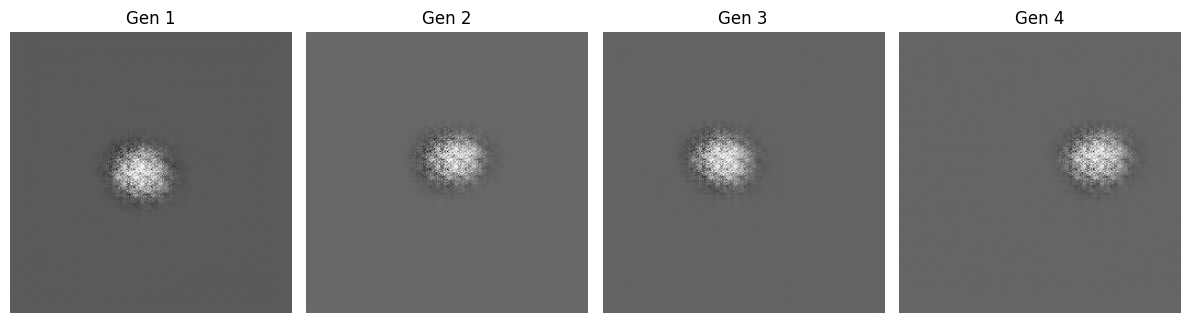

In [ ]:
# --- RUN GENERATION ---

# Settings
NUM_IMAGES = 4
TEMP = 0.8       # Try 0.7, 0.8, 1.0. Lower = cleaner single active regions.
TOP_K = 50       # Keep this around 50-100.

# Generate
generated_imgs = sample_solar_magnetograms(transformer, vqgan,
                                           n_samples=NUM_IMAGES,
                                           temperature=TEMP,
                                           top_k=TOP_K)

# Plotting
plt.figure(figsize=(12, 4))
for i in range(NUM_IMAGES):
    plt.subplot(1, NUM_IMAGES, i+1)
    plt.imshow(generated_imgs[i].squeeze(), cmap='gray') # squeeze to remove channel dim
    plt.title(f"Gen {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Completing images from top half...


100%|██████████| 128/128 [00:01<00:00, 100.44it/s]


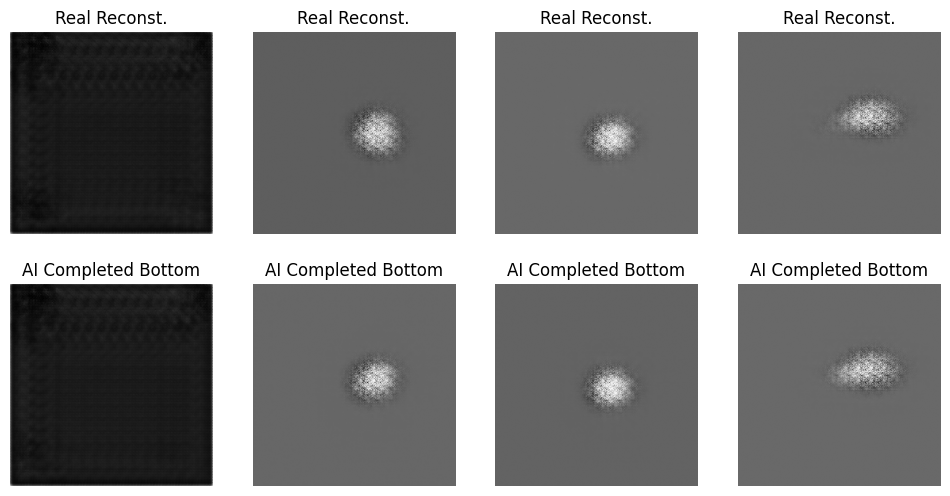

In [ ]:
# [CELL: DEBUGGING - HALF IMAGE COMPLETION]
def test_half_completion(vqgan, transformer, loader):
    transformer.eval()
    vqgan.eval()

    # 1. Get a real batch
    img, _ = next(iter(loader))
    img = img.to(HP["DEVICE"])[:4] # Take 4 images

    # 2. Encode to indices
    with torch.no_grad():
        z = vqgan.encoder(img)
        _, _, indices = vqgan.quantizer(z)
        indices = indices.view(img.shape[0], -1) # [4, 256]

    # 3. Cut them in half (Keep first 128 tokens, roughly top 8 lines)
    # 16x16 grid -> 128 is the top half
    half_indices = indices[:, :128]

    print("Completing images from top half...")

    # 4. Auto-regressively complete the rest
    # We start with the real top-half tokens
    generated = half_indices

    with torch.no_grad():
        for _ in tqdm(range(128)): # Generate remaining 128 tokens
            # Prepare input (add SOS if you used the shifted training method)
            # If using my previous "Shifted" code:
            sos = torch.full((4, 1), HP["SOS_TOKEN"], device=HP["DEVICE"])
            inp = torch.cat([sos, generated], dim=1)

            # Predict
            logits = transformer(inp)
            last_logits = logits[:, -1, :]

            # Sample (Greedy or Low Temp to see what it 'wants' to do)
            probs = F.softmax(last_logits, dim=-1)
            next_token = torch.argmax(probs, dim=-1).unsqueeze(1) # Greedy for debug

            generated = torch.cat([generated, next_token], dim=1)

    # 5. Decode
    rec = vqgan.decode_indices(generated.view(-1), shape=(16, 16))
    rec = (rec + 1) / 2

    # 6. Compare Real vs Completed
    real_rec = vqgan.decode_indices(indices.view(-1), shape=(16, 16))
    real_rec = (real_rec + 1) / 2

    # Plot
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(4):
        axs[0, i].imshow(real_rec[i].cpu().squeeze().detach().numpy(), cmap='gray')
        axs[0, i].set_title("Real Reconst.")
        axs[0, i].axis('off')

        axs[1, i].imshow(rec[i].cpu().squeeze().detach().numpy(), cmap='gray')
        axs[1, i].set_title("AI Completed Bottom")
        axs[1, i].axis('off')
    plt.show()

# Run the test
test_half_completion(vqgan, transformer, train_loader)

Generating with Nucleus Sampling (p=0.9)...


100%|██████████| 256/256 [00:03<00:00, 78.69it/s]


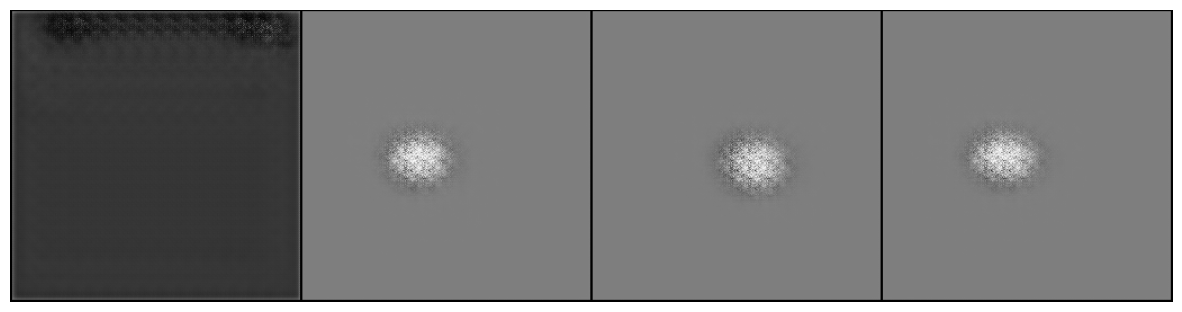

In [ ]:
# [CELL: IMPROVED SAMPLING]
def generate_better_sample(vqgan, transformer, temp=0.8, top_p=0.9):
    transformer.eval()
    vqgan.eval()

    bs = 4
    # Start with SOS (Index 256)
    indices = torch.full((bs, 1), HP["SOS_TOKEN"], device=HP["DEVICE"])

    seq_len = (HP["IMG_SIZE"] // 16) ** 2

    print(f"Generating with Nucleus Sampling (p={top_p})...")
    with torch.no_grad():
        for _ in tqdm(range(seq_len)):
            logits = transformer(indices)
            last_logits = logits[:, -1, :] / temp

            # Nucleus Sampling (Top-P)
            probs = F.softmax(last_logits, dim=-1)
            sorted_probs, sorted_indices = torch.sort(probs, descending=True)
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

            # Remove tokens with cumulative probability above the threshold
            sorted_indices_to_remove = cumulative_probs > top_p
            # Shift the indices to the right to keep also the first token above the threshold
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0

            indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
            last_logits[indices_to_remove] = float('-inf')

            # Sample
            new_probs = F.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(new_probs, num_samples=1)
            indices = torch.cat([indices, next_token], dim=1)

    # Decode (Remove SOS first)
    rec = vqgan.decode_indices(indices[:, 1:].reshape(-1), shape=(16, 16))
    rec = (rec + 1) / 2

    grid = make_grid(rec, nrow=4)
    plt.figure(figsize=(15, 5))
    plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

# Try this!
generate_better_sample(vqgan, transformer, temp=0.7, top_p=0.9)

In [ ]:
#  [CELL: CHECK CODEBOOK]
def check_codebook_usage(vqgan, loader):
    vqgan.eval()
    all_indices = []

    print("Checking codebook usage on 5 batches...")
    for i, (img, _) in enumerate(loader):
        if i > 5: break
        img = img.to(HP["DEVICE"])
        with torch.no_grad():
            z = vqgan.encoder(img)
            _, _, indices = vqgan.quantizer(z)
            all_indices.append(indices.cpu().numpy().flatten())

    all_indices = np.concatenate(all_indices)

    plt.figure(figsize=(10, 4))
    plt.hist(all_indices, bins=HP["N_CODES"])
    plt.title("Codebook Usage Histogram")
    plt.xlabel("Code Index")
    plt.ylabel("Frequency")
    plt.show()

    print(f"Unique codes used: {len(np.unique(all_indices))} / {HP['N_CODES']}")

check_codebook_usage(vqgan, train_loader)

Checking codebook usage on 5 batches...


KeyboardInterrupt: 

Generating Sweep...


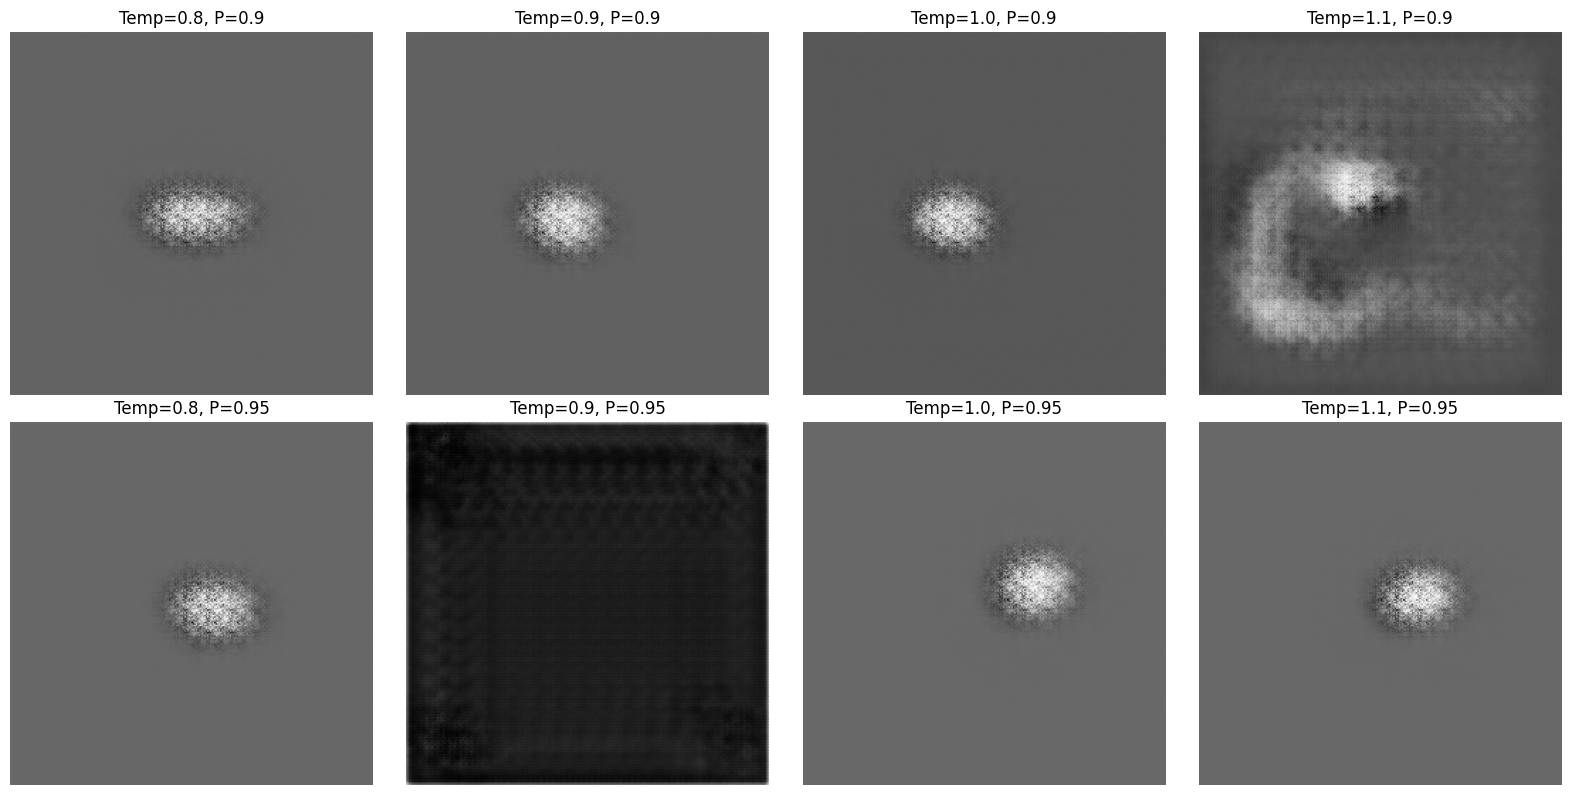

In [ ]:
# [CELL: TEMPERATURE SWEEP]
def generate_temperature_sweep(vqgan, transformer):
    transformer.eval()
    vqgan.eval()

    temps = [0.8, 0.9, 1.0, 1.1] # Pushing temp > 1.0 can bring back detail!
    p_values = [0.9, 0.95]       # Top-P prevents it from breaking into static

    fig, axes = plt.subplots(len(p_values), len(temps), figsize=(16, 8))

    bs = 1
    seq_len = (HP["IMG_SIZE"] // 16) ** 2

    print("Generating Sweep...")

    for r, p in enumerate(p_values):
        for c, t in enumerate(temps):

            # Start with SOS
            indices = torch.full((bs, 1), HP["SOS_TOKEN"], device=HP["DEVICE"])

            with torch.no_grad():
                for _ in range(seq_len):
                    logits = transformer(indices)
                    last_logits = logits[:, -1, :] / t # Apply Temp

                    # Nucleus Sampling
                    probs = F.softmax(last_logits, dim=-1)
                    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

                    sorted_indices_to_remove = cumulative_probs > p
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = 0

                    indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                    last_logits[indices_to_remove] = float('-inf')

                    new_probs = F.softmax(last_logits, dim=-1)
                    next_token = torch.multinomial(new_probs, num_samples=1)
                    indices = torch.cat([indices, next_token], dim=1)

            # Decode
            rec = vqgan.decode_indices(indices[:, 1:].reshape(-1), shape=(16, 16))
            rec = (rec + 1) / 2

            ax = axes[r][c]
            ax.imshow(rec.cpu().squeeze().detach(), cmap='gray') # Added .detach()
            ax.axis('off')
            ax.set_title(f"Temp={t}, P={p}")

    plt.tight_layout()
    plt.show()

generate_temperature_sweep(vqgan, transformer)

Shape: torch.Size([1, 128, 128])
Label: tensor(1)


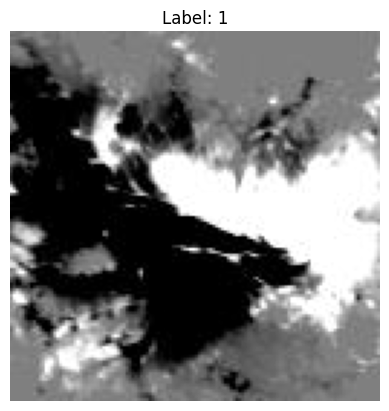

In [ ]:
train_ds = ARDataset(train_balanced, HP["ROOT_DIR"], transform=transform)
img, label = train_ds[2]
print("Shape:", img.shape)
print("Label:", label)

img_np = img.squeeze().numpy()

plt.imshow(img_np, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [ ]:
# ==========================================
# 1. CONFIGURATION
# ==========================================
HP = {
    # Data & System
    "IMG_SIZE": 256,
    "ROOT_DIR": "/Users/pranjal/preprocessed_SHARPS_JPGS/preprocessed_hourly_all/",
    "METADATA_PATH": "/Users/pranjal/preprocessed_SHARPS_JPGS/complete_hourly_dataset_lon_-90_to_90_cleaned.csv",
    "SAVE_DIR": "./results/solar_synthesis_v2",
    "DEVICE": "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu",

    # Stage 1: VQGAN Hyperparameters (Optimized for Scientific Data)
    "Z_DIM": 256,             # Increased from 64 to avoid manifold collision
    "N_CODES": 1024,          # Increased from 256 to prevent codebook collapse
    "EMBED_DIM": 256,
    "DOWN_FACTOR": 8,         # 256 -> 32x32 latent map
    "V_BATCH_SIZE": 32,       # Virtual batch size (via gradient accumulation)
    "P_BATCH_SIZE": 8,        # Physical batch size
    "LR_G": 4.5e-6,           # Lower LR for stability
    "LR_D": 4.5e-6,
    "PERCEPTUAL_WEIGHT": 1.0, # CRITICAL: Enforces structural shape (requires LPIPS)
    "ADV_WEIGHT": 0.1,        # Lowered to prevent texture hallucination
    "EPOCHS_STAGE1": 50,

    # Stage 2: Transformer Hyperparameters
    "GPT_LAYERS": 12,
    "GPT_HEADS": 8,
    "GPT_EMBD": 512,
    "GPT_DROPOUT": 0.1,
    "LR_T": 1e-4,
    "EPOCHS_STAGE2": 50,
}

os.makedirs(HP, exist_ok=True)
print(f"Running on device: {HP}")

Using device: mps
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/pranjal/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pranjal/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/pranjal/Library/Python/3.9/lib/python/site-packages/lpips/weights/v0.1/alex.pth
LPIPS available


Epoch 01 | G=0.1759 D=0.8154 R=0.1560 P=0.0000 adv_w=0.000


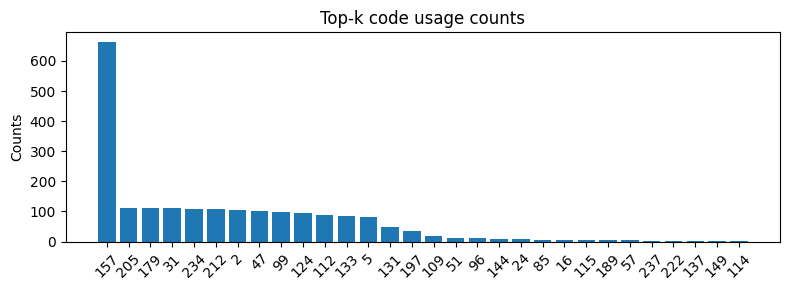

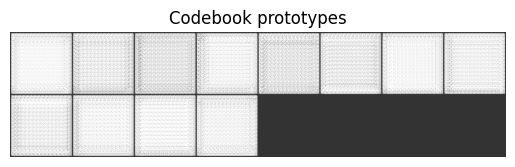

Epoch 02 | G=0.0884 D=0.5066 R=0.0776 P=0.0000 adv_w=0.000


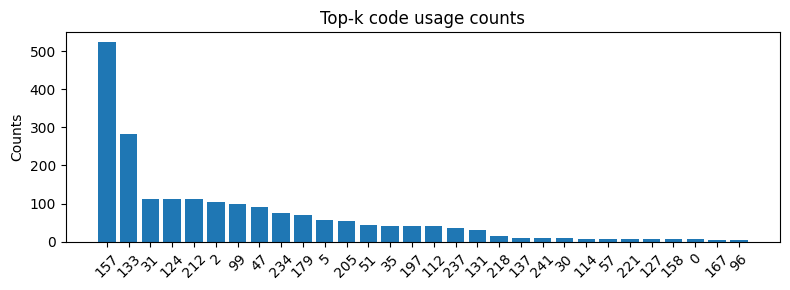

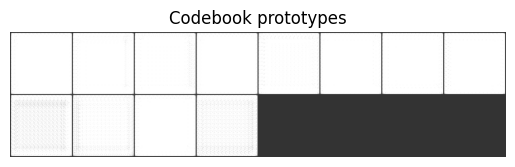

Epoch 03 | G=0.0710 D=0.3171 R=0.0627 P=0.0000 adv_w=0.000


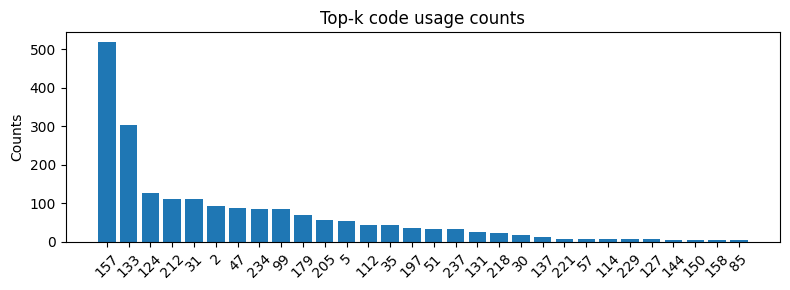

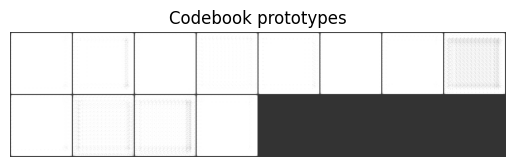

Epoch 04 | G=0.0640 D=0.2418 R=0.0568 P=0.0000 adv_w=0.000


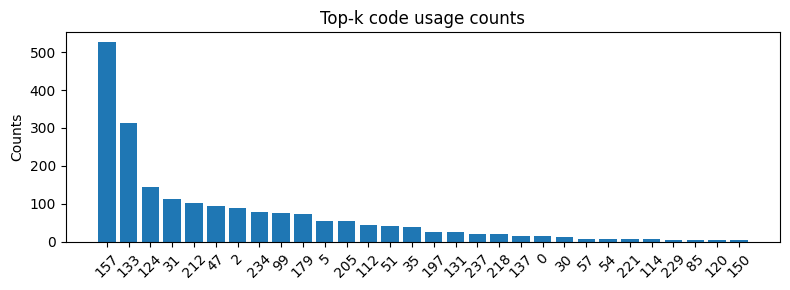

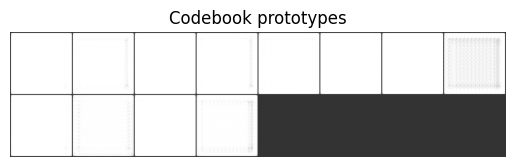

Epoch 05 | G=0.0596 D=0.1995 R=0.0534 P=0.0000 adv_w=0.000


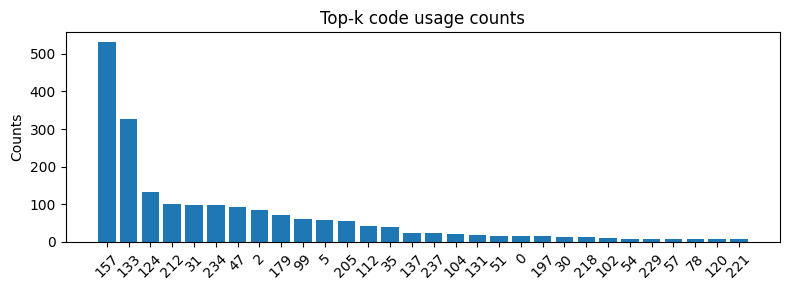

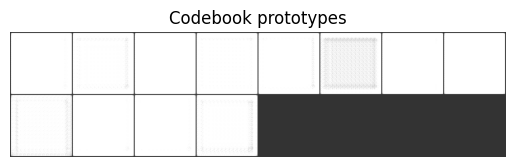

Epoch 06 | G=0.0565 D=0.1665 R=0.0509 P=0.0000 adv_w=0.000


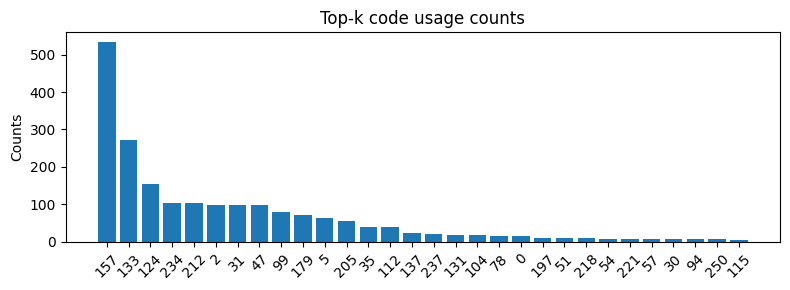

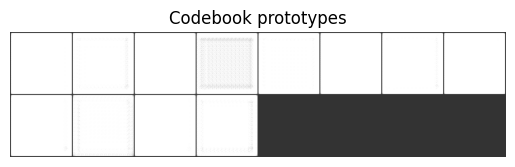

Epoch 07 | G=0.0545 D=0.1503 R=0.0494 P=0.0000 adv_w=0.000


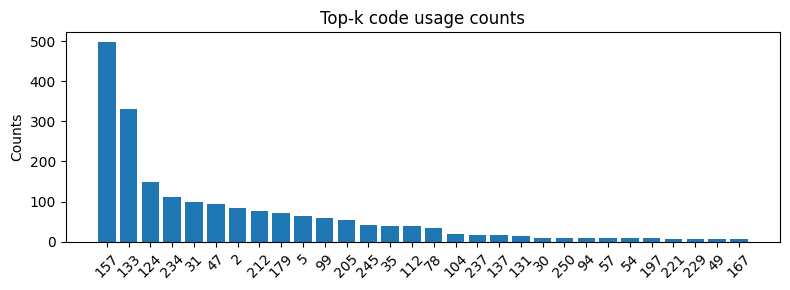

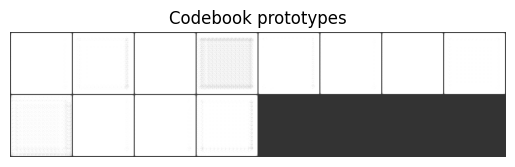

Epoch 08 | G=0.0529 D=0.1339 R=0.0480 P=0.0000 adv_w=0.000


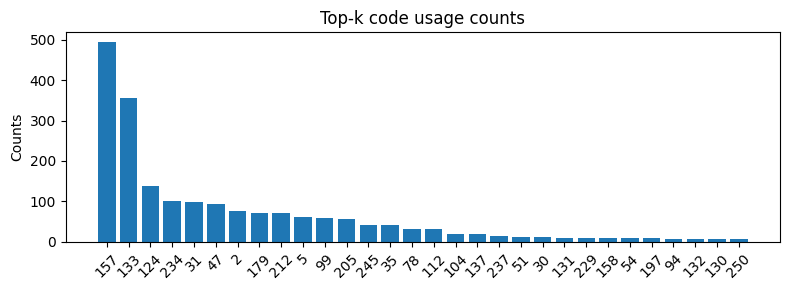

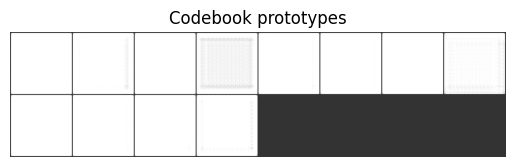

Epoch 09 | G=0.0513 D=0.1249 R=0.0466 P=0.0000 adv_w=0.000


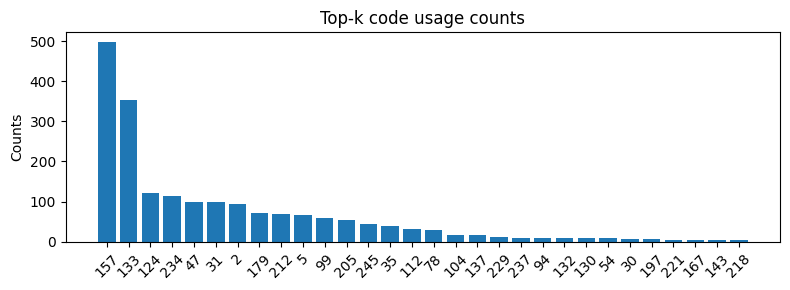

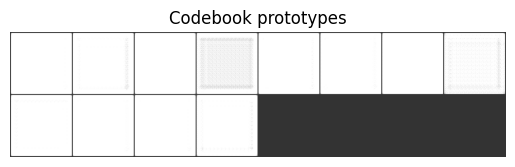

Epoch 10 | G=0.0500 D=0.1161 R=0.0456 P=0.0000 adv_w=0.000


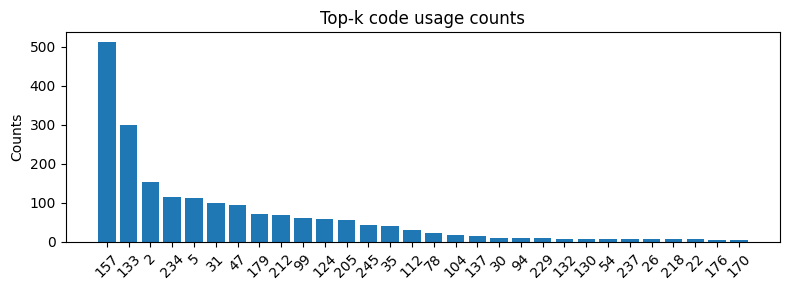

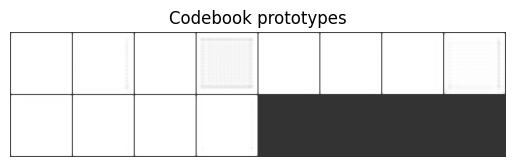

Epoch 11 | G=0.0626 D=1.4119 R=0.0594 P=0.0000 adv_w=0.007


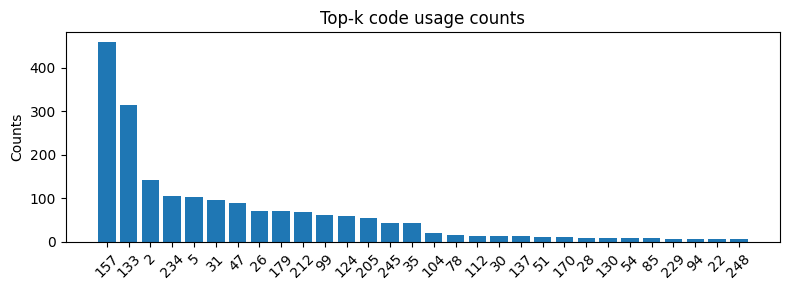

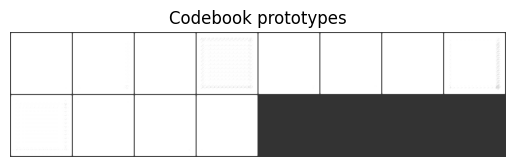

Epoch 12 | G=0.0607 D=0.9872 R=0.0521 P=0.0000 adv_w=0.014


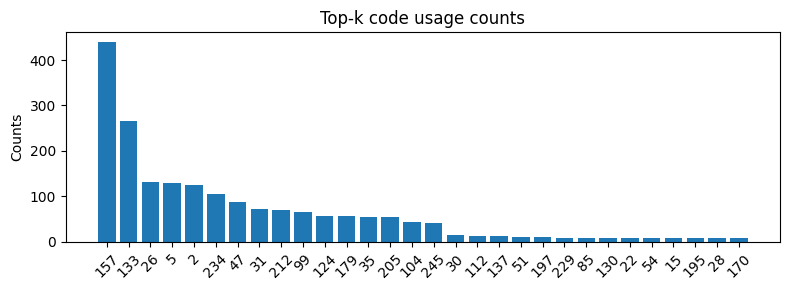

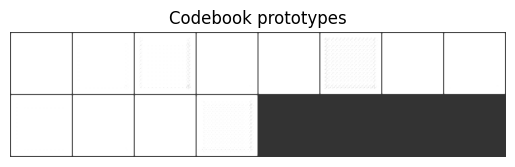

Epoch 13 | G=0.0639 D=0.9840 R=0.0534 P=0.0000 adv_w=0.021


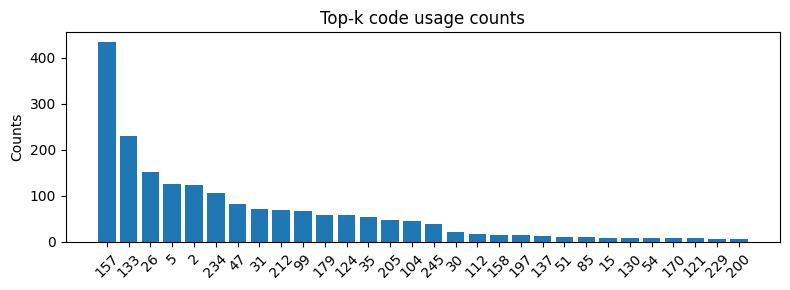

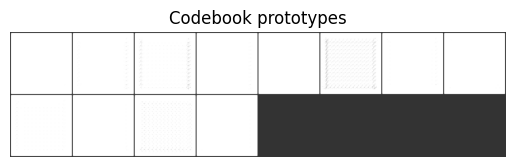

Epoch 14 | G=0.0687 D=0.9971 R=0.0548 P=0.0000 adv_w=0.029


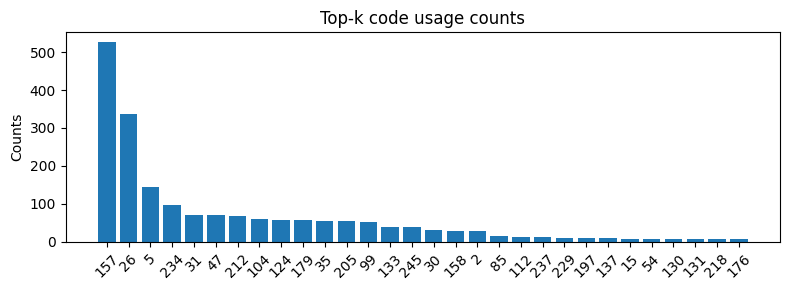

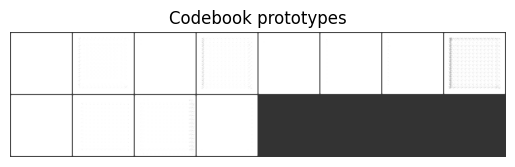

Epoch 15 | G=0.0767 D=1.0292 R=0.0572 P=0.0000 adv_w=0.036


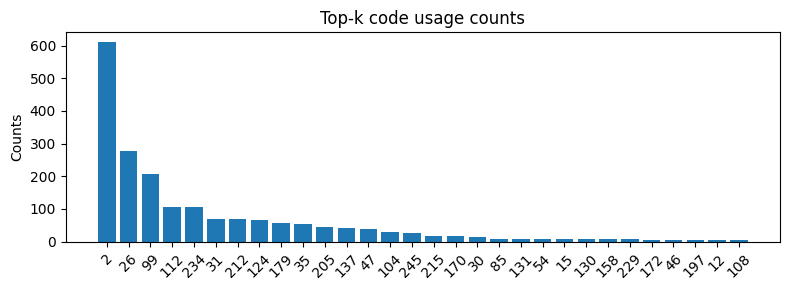

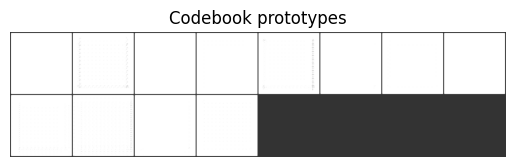

Epoch 16 | G=0.0733 D=0.9833 R=0.0552 P=0.0000 adv_w=0.043


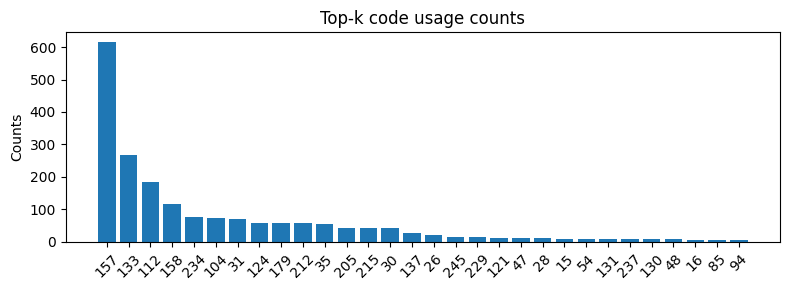

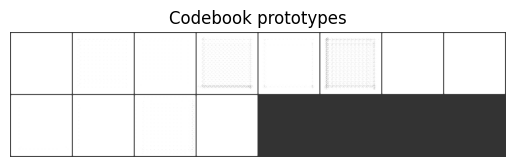

Epoch 17 | G=0.0798 D=1.0140 R=0.0584 P=0.0000 adv_w=0.050


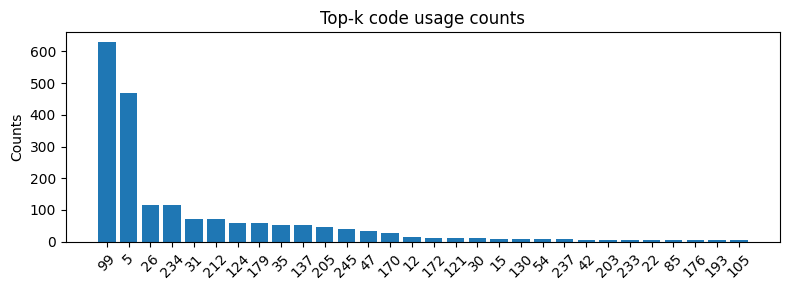

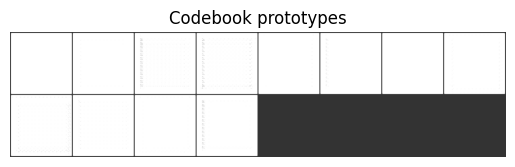

Epoch 18 | G=0.0685 D=1.0167 R=0.0566 P=0.0000 adv_w=0.057


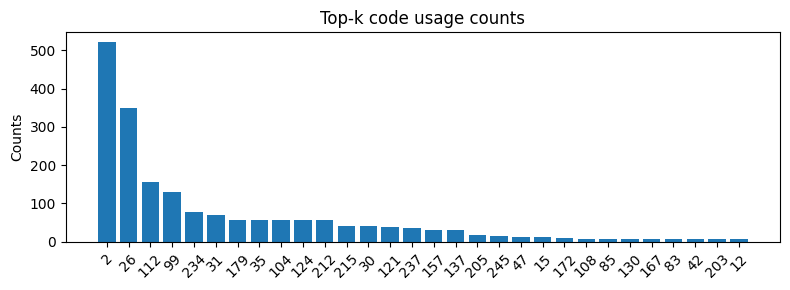

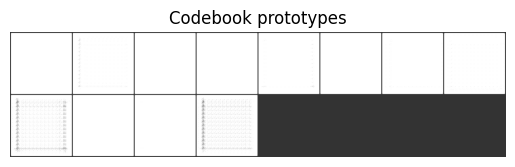

Epoch 19 | G=0.0741 D=0.9982 R=0.0578 P=0.0000 adv_w=0.064


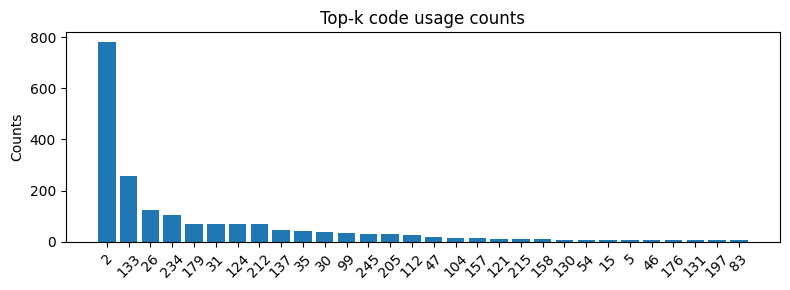

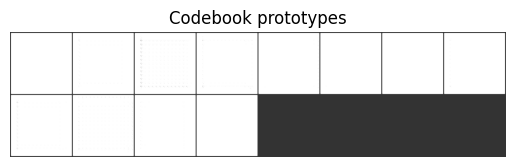

Epoch 20 | G=0.0733 D=1.0107 R=0.0578 P=0.0000 adv_w=0.071


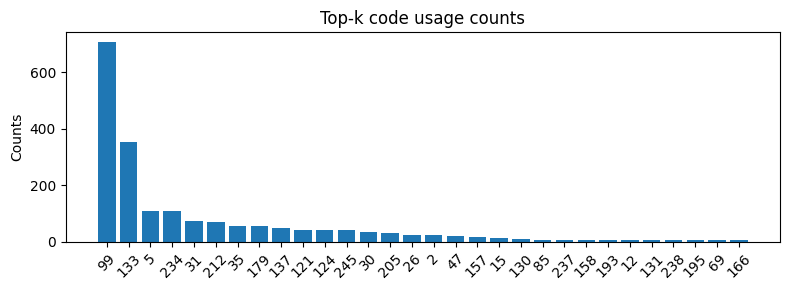

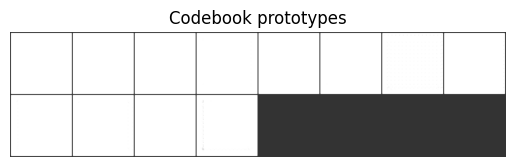

Epoch 21 | G=0.0706 D=1.0200 R=0.0585 P=0.0000 adv_w=0.079


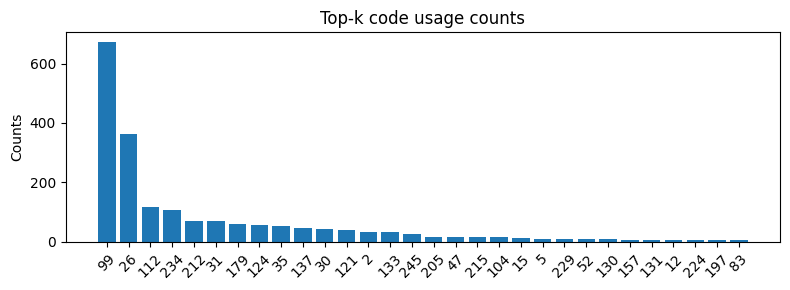

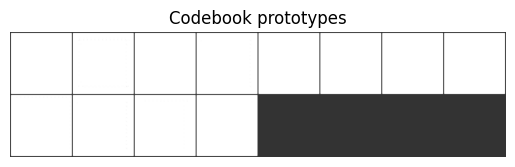

Epoch 22 | G=0.0940 D=1.0364 R=0.0613 P=0.0000 adv_w=0.086


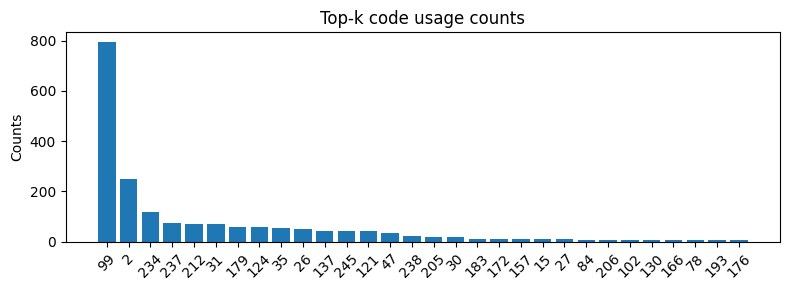

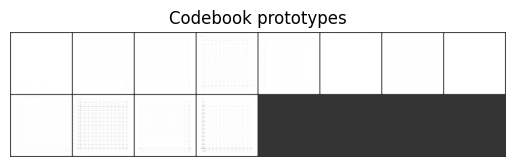

Epoch 23 | G=0.0875 D=1.0234 R=0.0592 P=0.0000 adv_w=0.093


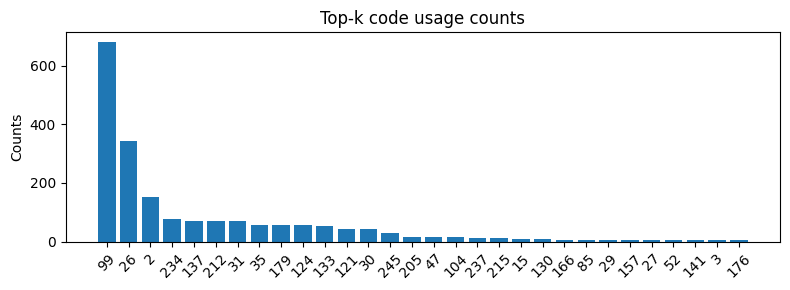

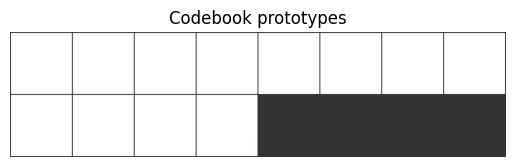

Epoch 24 | G=0.0773 D=1.0146 R=0.0553 P=0.0000 adv_w=0.100


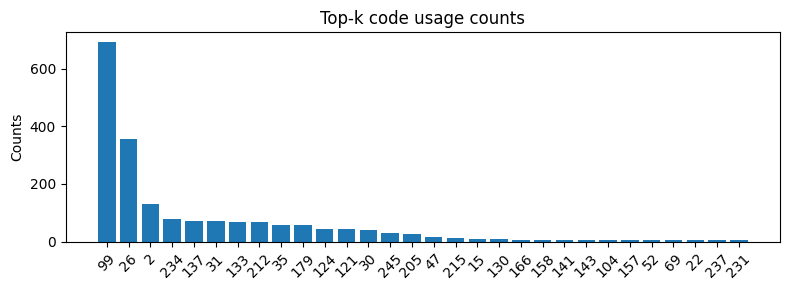

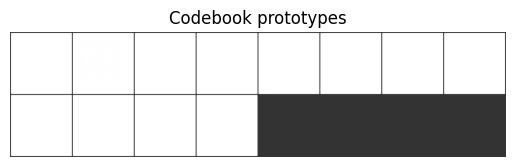

Epoch 25 | G=0.0695 D=1.0108 R=0.0551 P=0.0000 adv_w=0.107


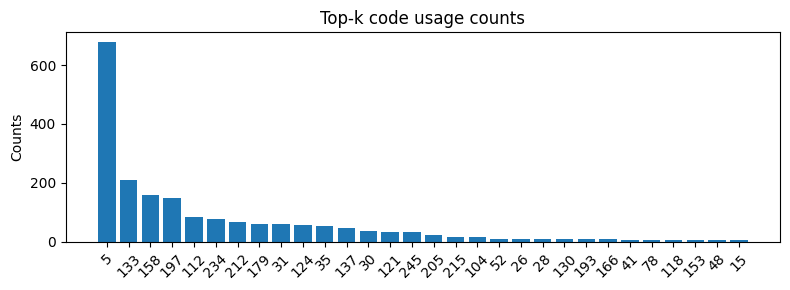

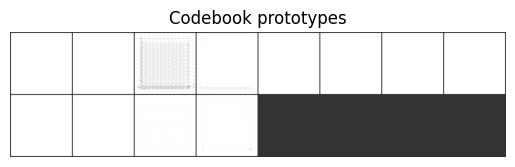

Epoch 26 | G=0.0437 D=1.0215 R=0.0560 P=0.0000 adv_w=0.114


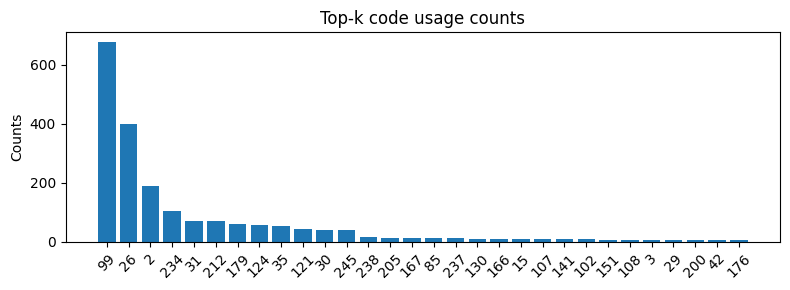

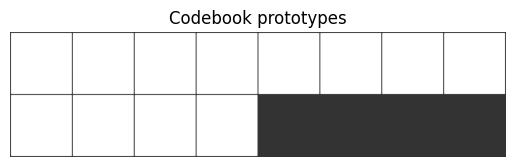

Epoch 27 | G=0.0618 D=1.0043 R=0.0535 P=0.0000 adv_w=0.121


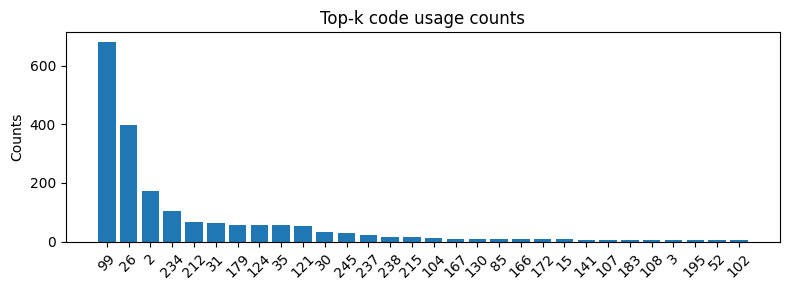

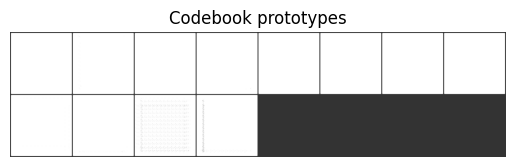

Epoch 28 | G=0.0635 D=1.0213 R=0.0571 P=0.0000 adv_w=0.129


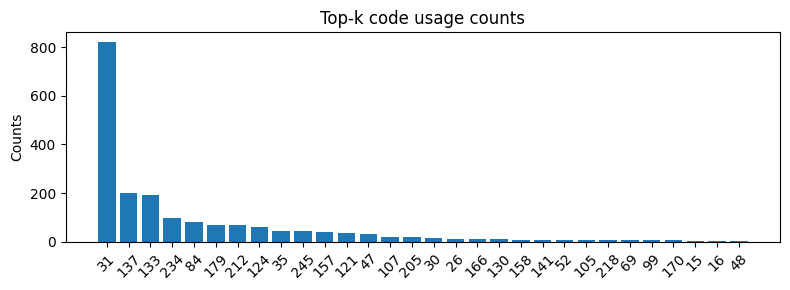

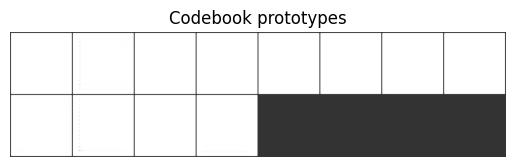

Epoch 29 | G=0.0301 D=1.0179 R=0.0564 P=0.0000 adv_w=0.136


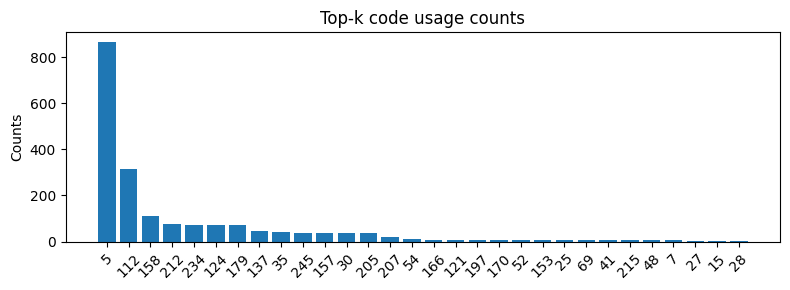

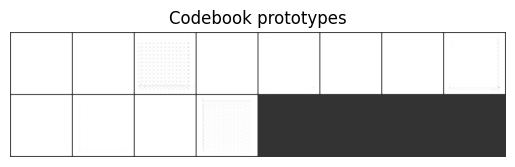

Epoch 30 | G=0.0230 D=1.0260 R=0.0576 P=0.0000 adv_w=0.143


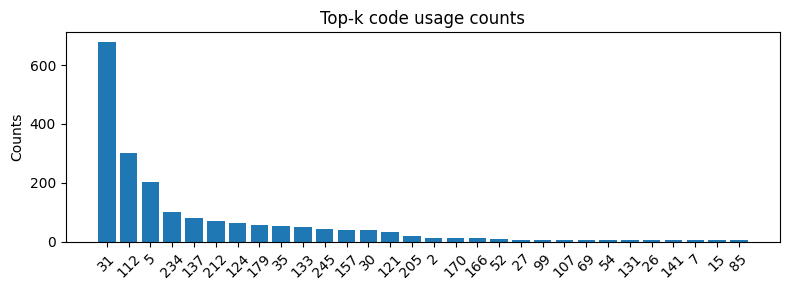

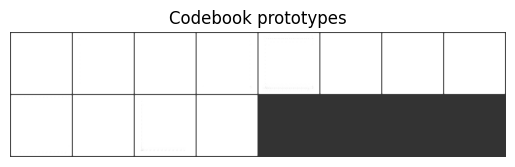

Epoch 31 | G=0.0331 D=1.0078 R=0.0528 P=0.0000 adv_w=0.150


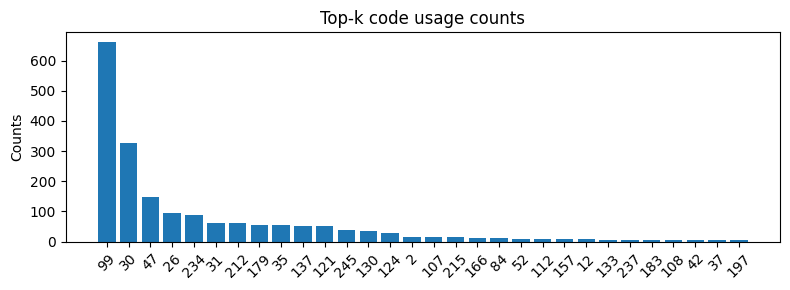

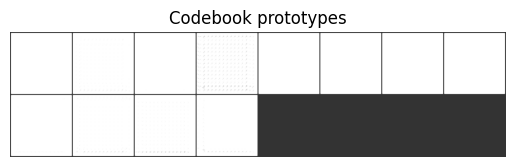

Epoch 32 | G=0.0316 D=1.0079 R=0.0516 P=0.0000 adv_w=0.157


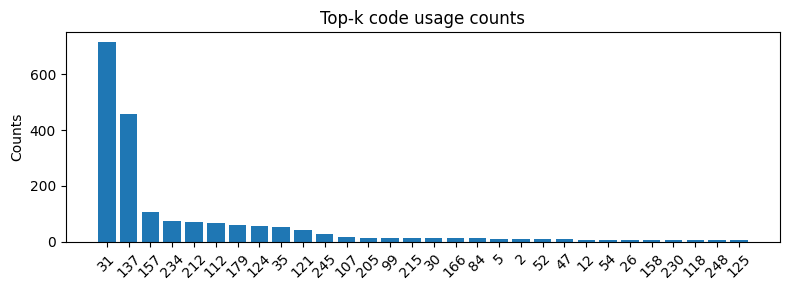

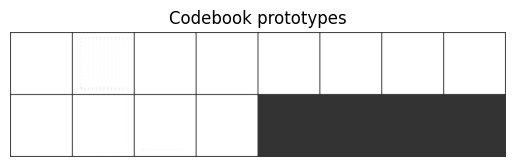

Epoch 33 | G=0.0219 D=1.0086 R=0.0520 P=0.0000 adv_w=0.164


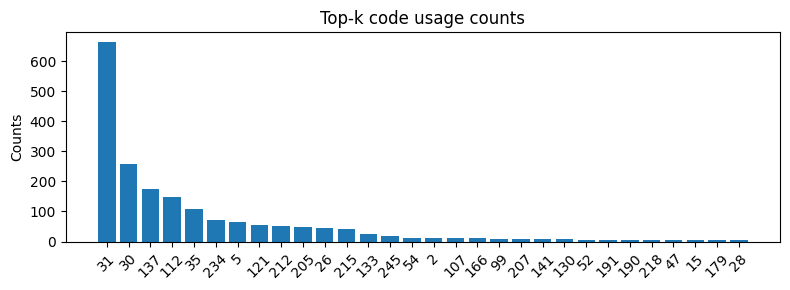

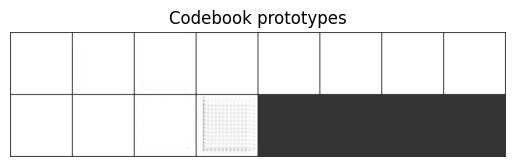

Epoch 34 | G=0.0286 D=1.0037 R=0.0497 P=0.0000 adv_w=0.171


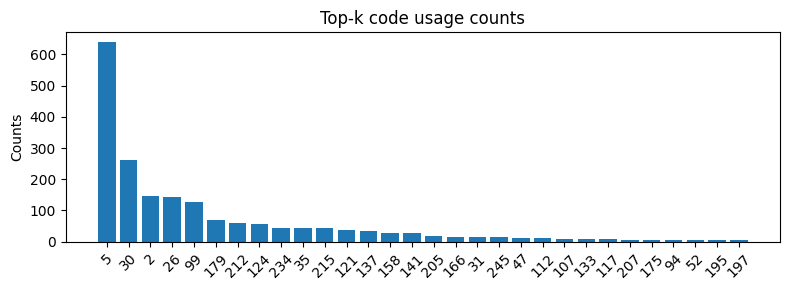

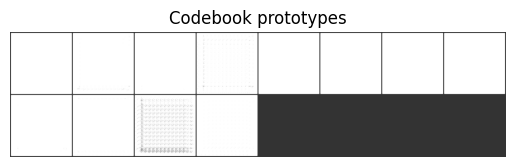

Epoch 35 | G=0.0289 D=1.0105 R=0.0525 P=0.0000 adv_w=0.179


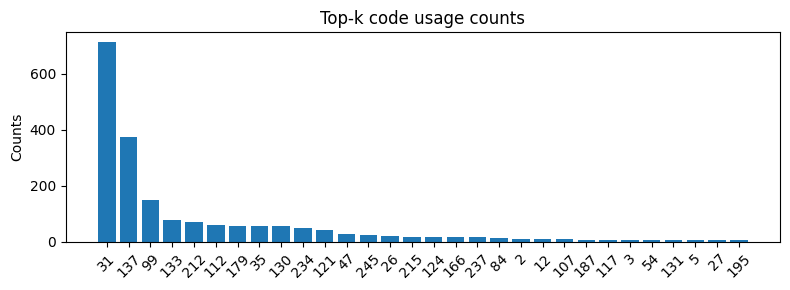

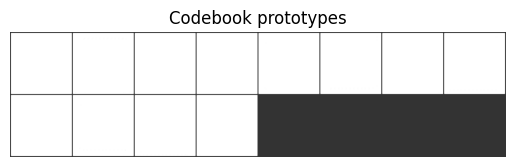

Epoch 36 | G=0.0236 D=1.0057 R=0.0506 P=0.0000 adv_w=0.186


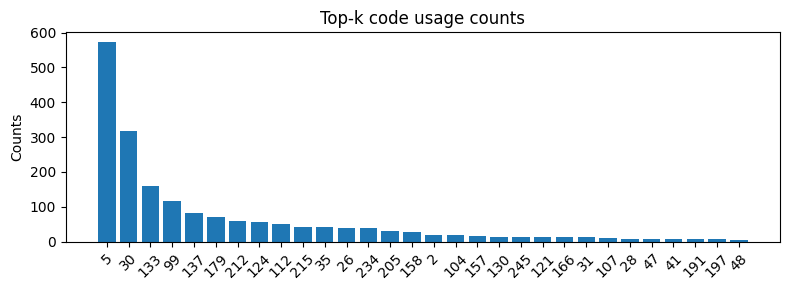

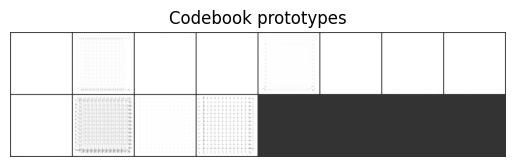

Epoch 37 | G=0.0318 D=1.0103 R=0.0532 P=0.0000 adv_w=0.193


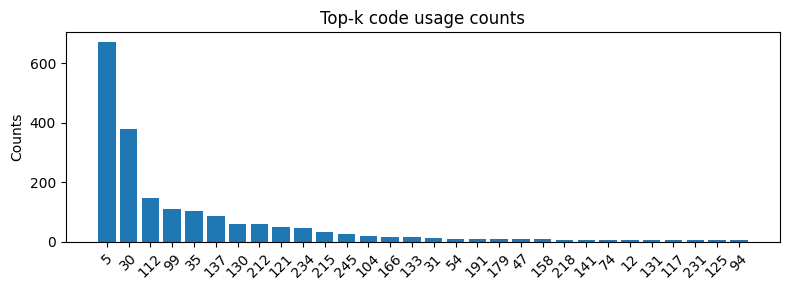

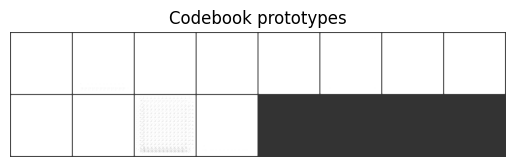

Epoch 38 | G=0.0406 D=1.0022 R=0.0487 P=0.0000 adv_w=0.200


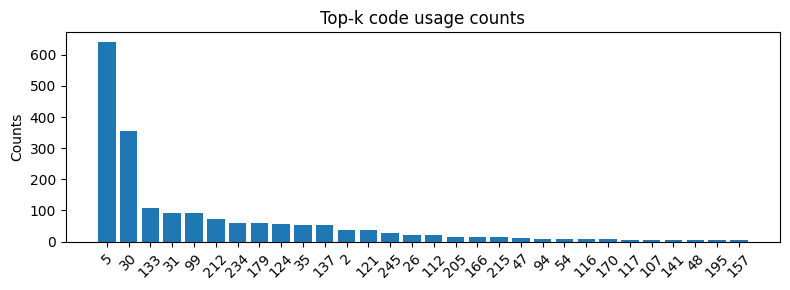

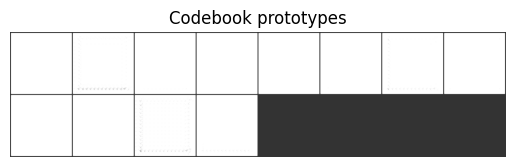

Epoch 39 | G=0.0317 D=1.0091 R=0.0520 P=0.0000 adv_w=0.207


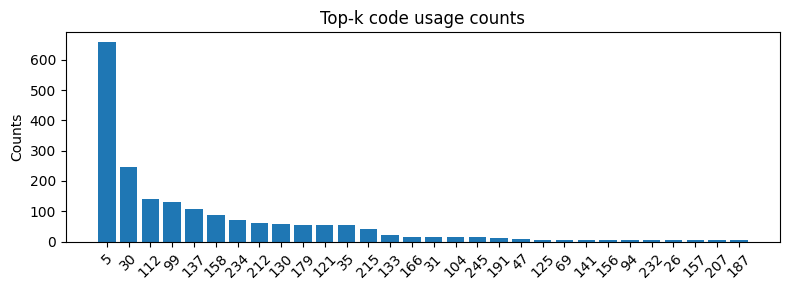

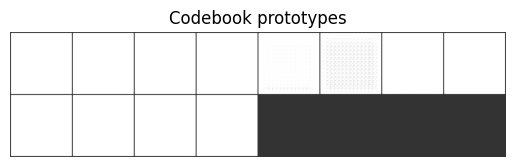

Epoch 40 | G=-0.0135 D=1.0104 R=0.0517 P=0.0000 adv_w=0.214


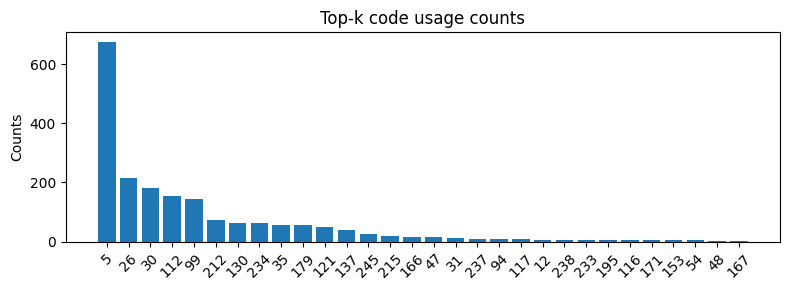

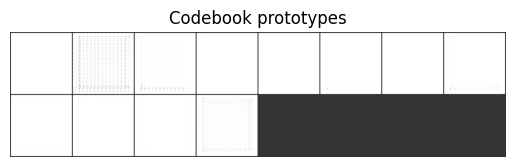

Epoch 41 | G=-0.0145 D=1.0055 R=0.0498 P=0.0000 adv_w=0.221


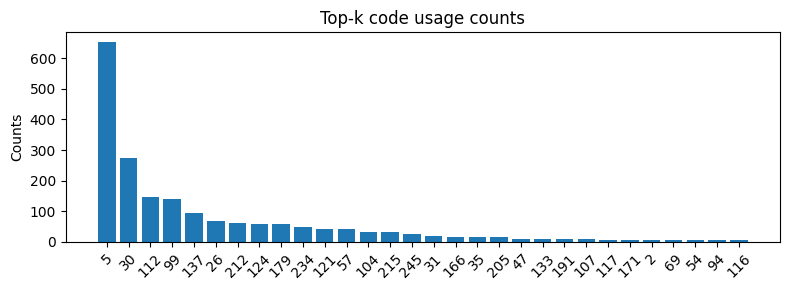

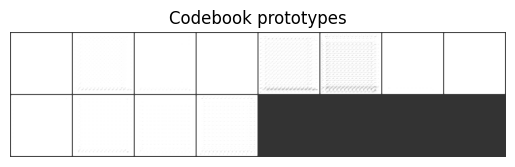

Epoch 42 | G=-0.0135 D=1.0059 R=0.0511 P=0.0000 adv_w=0.229


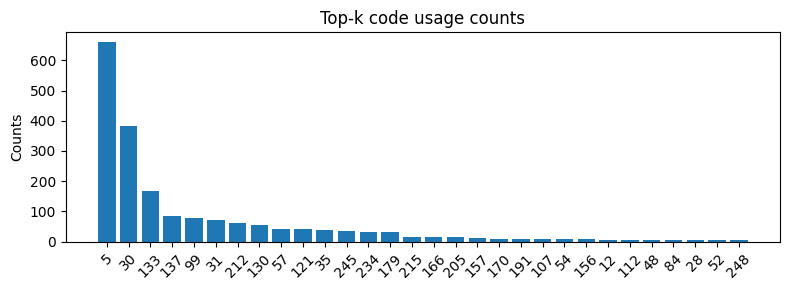

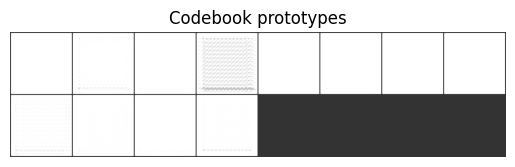

Epoch 43 | G=-0.0237 D=1.0073 R=0.0519 P=0.0000 adv_w=0.236


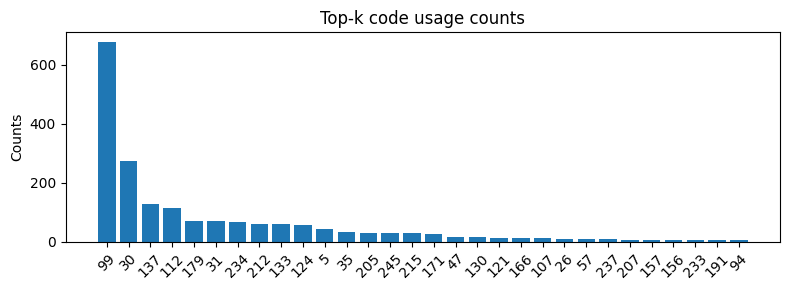

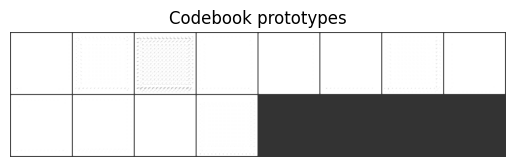

Epoch 44 | G=-0.0518 D=1.0022 R=0.0491 P=0.0000 adv_w=0.243


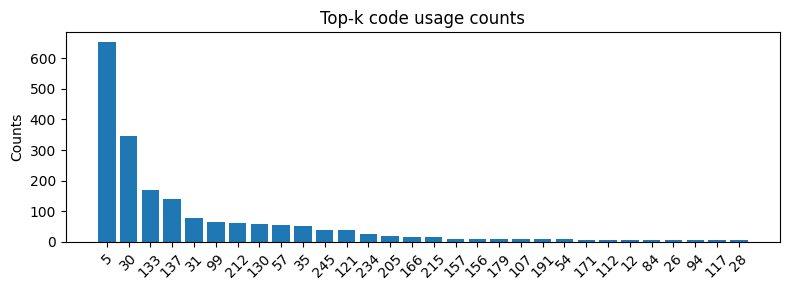

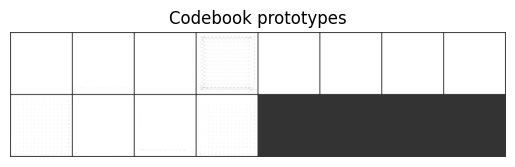

Epoch 45 | G=-0.0379 D=1.0068 R=0.0507 P=0.0000 adv_w=0.250


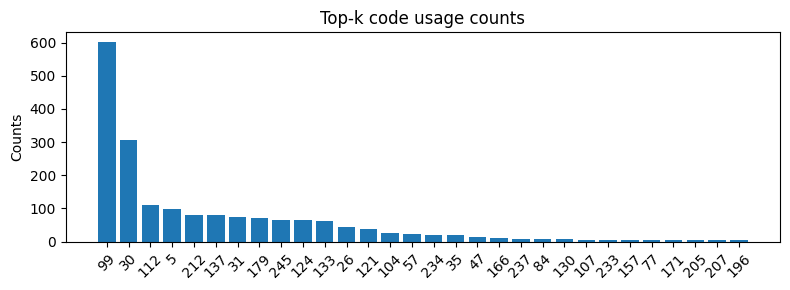

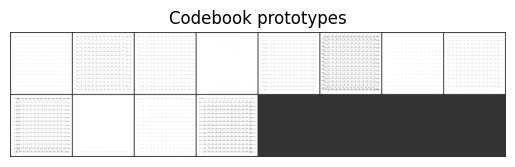

Epoch 46 | G=-0.0099 D=1.0084 R=0.0516 P=0.0000 adv_w=0.257


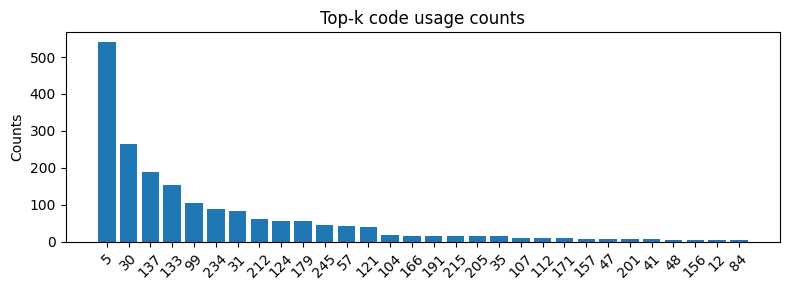

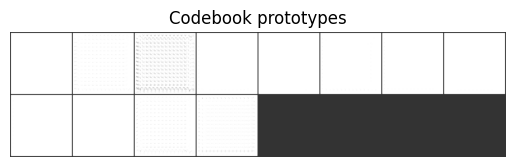

Epoch 47 | G=-0.0225 D=1.0085 R=0.0523 P=0.0000 adv_w=0.264


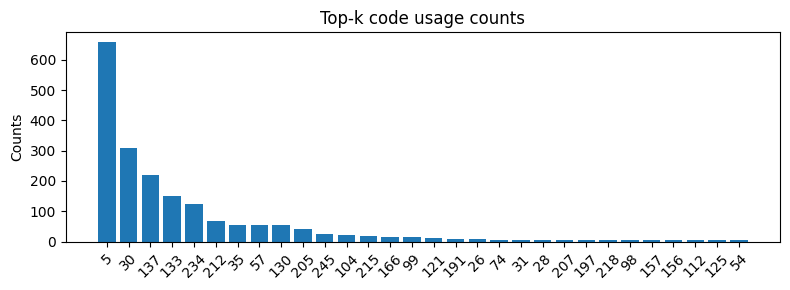

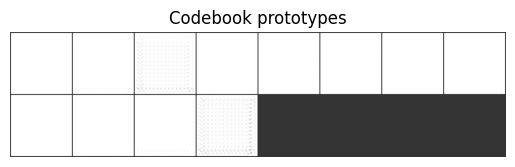

Epoch 48 | G=-0.0215 D=1.0013 R=0.0498 P=0.0000 adv_w=0.271


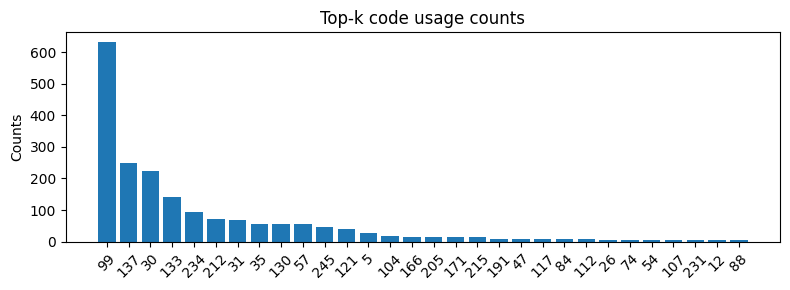

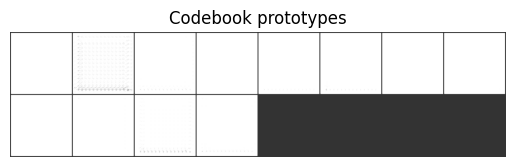

Epoch 49 | G=-0.0217 D=1.0060 R=0.0506 P=0.0000 adv_w=0.279


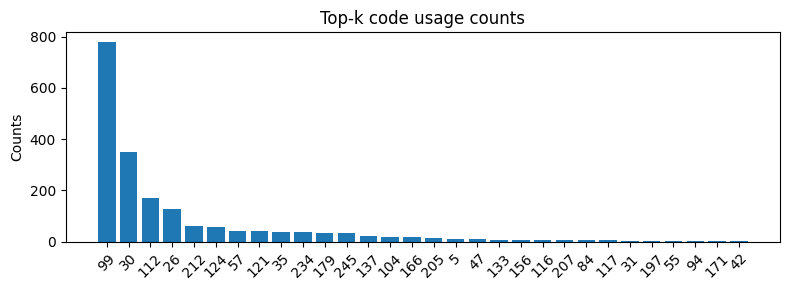

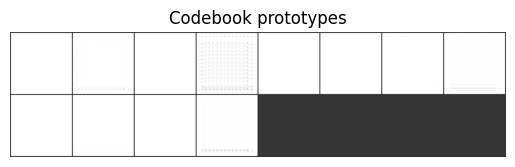

Epoch 50 | G=-0.0329 D=1.0072 R=0.0524 P=0.0000 adv_w=0.286


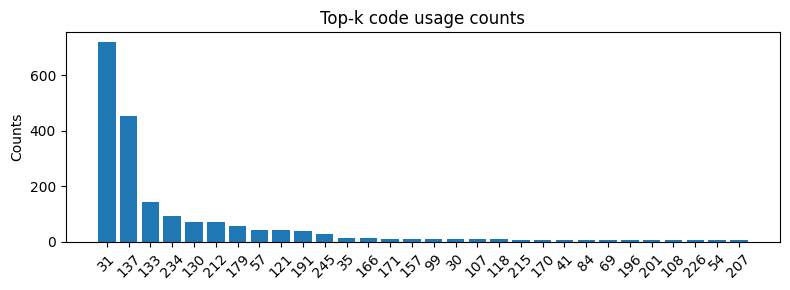

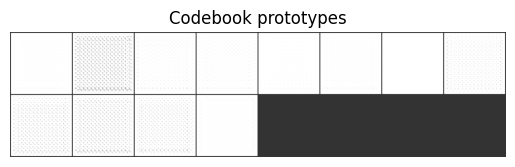

Epoch 51 | G=-0.0361 D=1.0067 R=0.0516 P=0.0000 adv_w=0.293


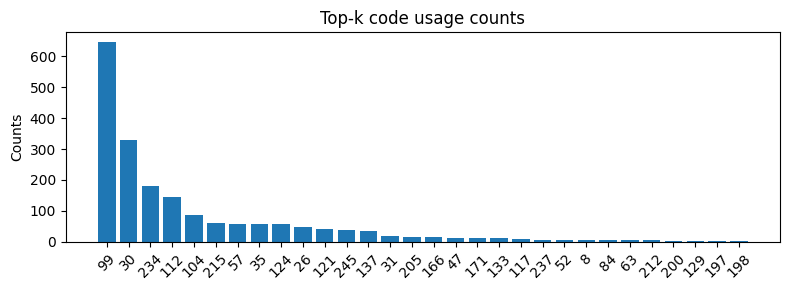

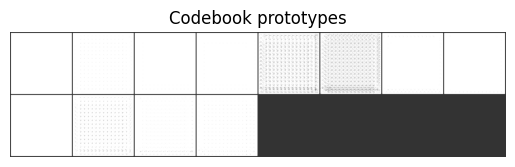

Epoch 52 | G=-0.0346 D=1.0235 R=0.0636 P=0.0000 adv_w=0.300


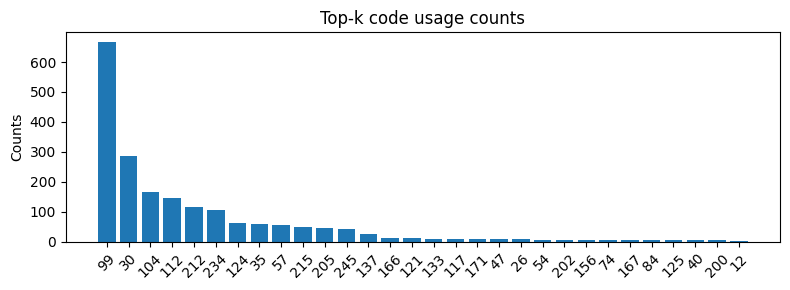

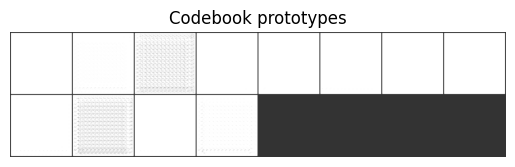

Epoch 53 | G=-0.0578 D=1.0012 R=0.0458 P=0.0000 adv_w=0.307


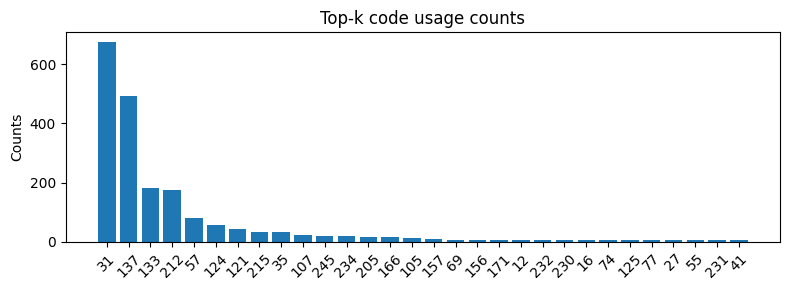

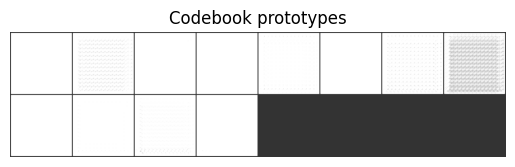

Epoch 54 | G=-0.0556 D=1.0030 R=0.0472 P=0.0000 adv_w=0.314


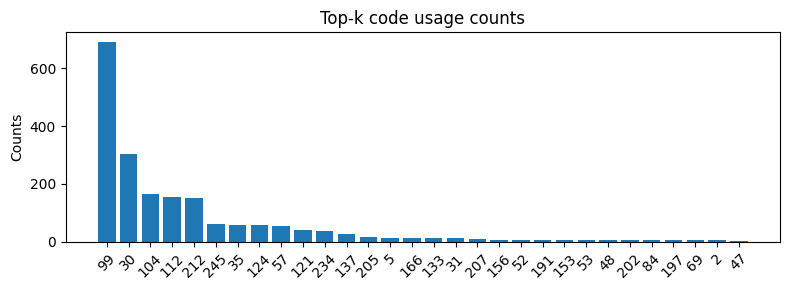

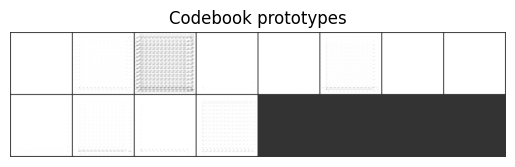

Epoch 55 | G=-0.0413 D=1.0073 R=0.0495 P=0.0000 adv_w=0.321


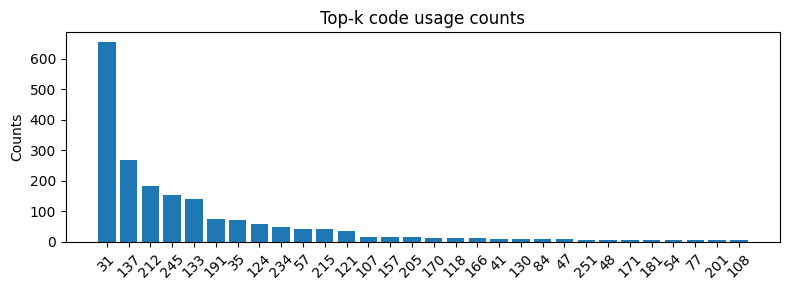

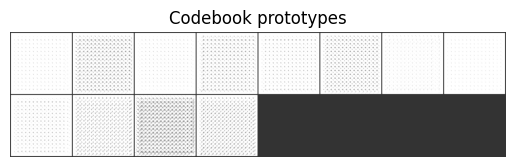

Epoch 56 | G=-0.0674 D=1.0159 R=0.0547 P=0.0000 adv_w=0.329


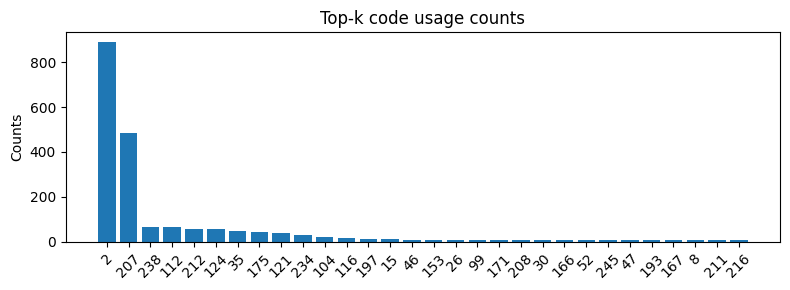

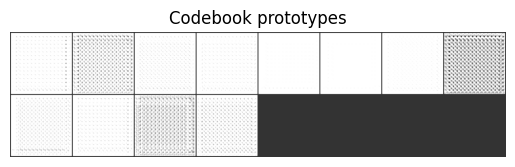

Epoch 57 | G=-0.1042 D=1.0052 R=0.0505 P=0.0000 adv_w=0.336


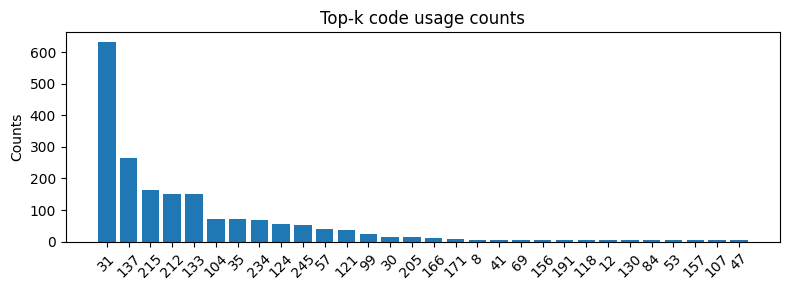

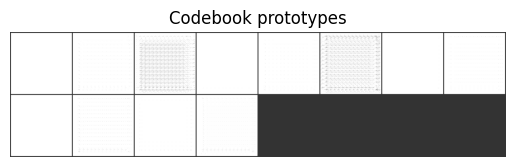

Epoch 58 | G=-0.0775 D=1.0058 R=0.0495 P=0.0000 adv_w=0.343


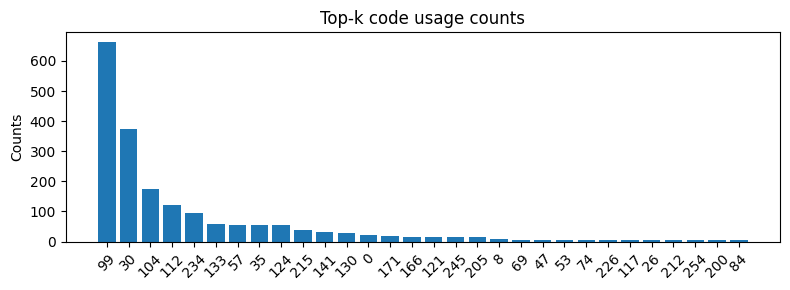

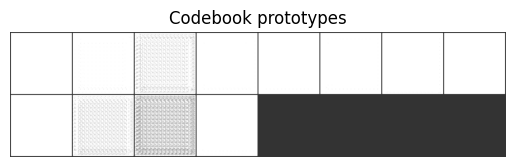

Epoch 59 | G=-0.0600 D=1.0090 R=0.0479 P=0.0000 adv_w=0.350


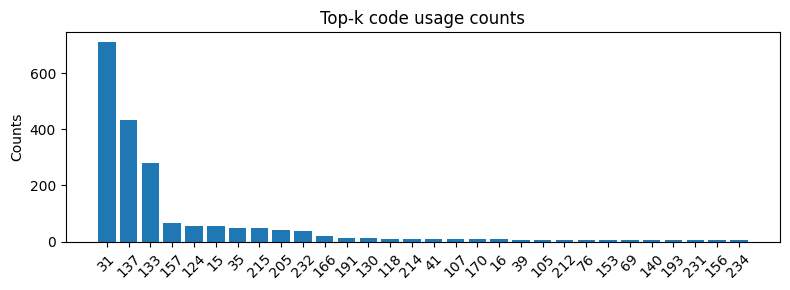

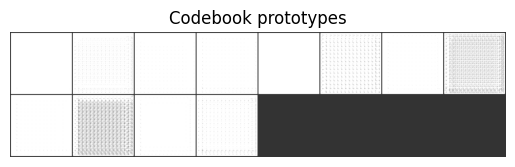

Epoch 60 | G=-0.0755 D=1.0030 R=0.0476 P=0.0000 adv_w=0.357


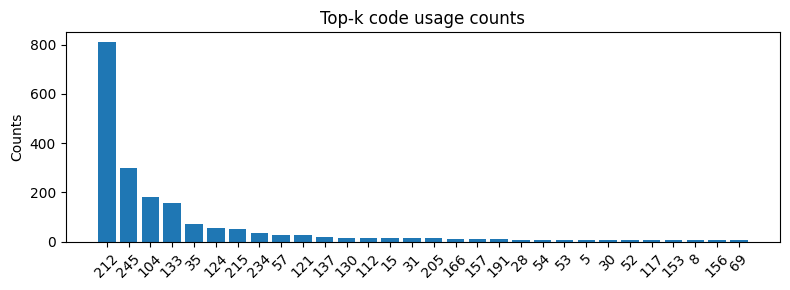

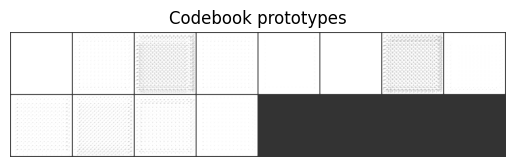

Epoch 61 | G=-0.0813 D=1.0038 R=0.0478 P=0.0000 adv_w=0.364


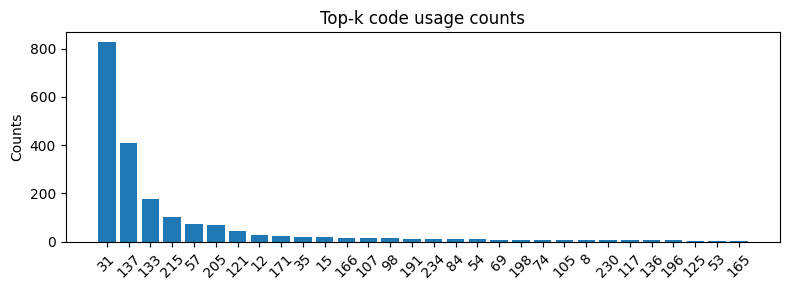

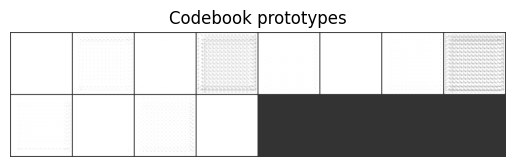

Epoch 62 | G=-0.0558 D=1.0050 R=0.0486 P=0.0000 adv_w=0.371


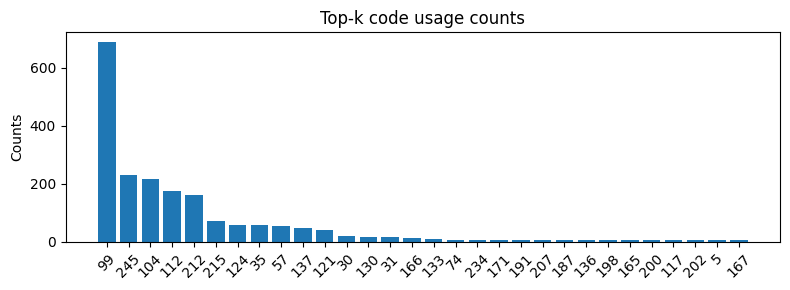

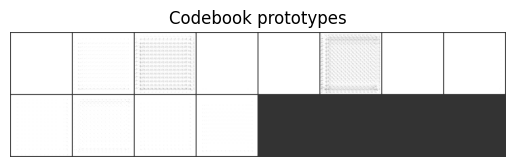

Epoch 63 | G=-0.0453 D=1.0024 R=0.0473 P=0.0000 adv_w=0.379


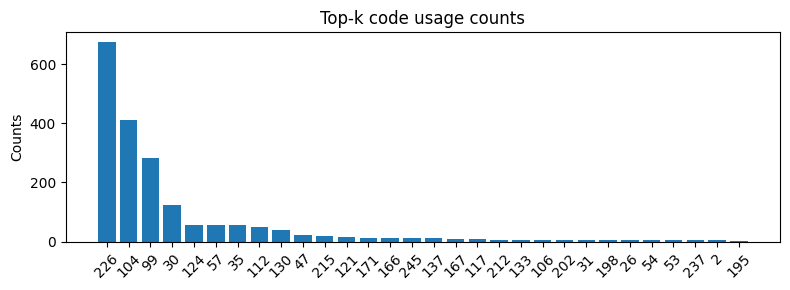

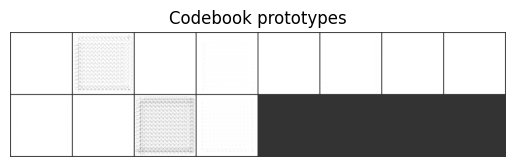

Epoch 64 | G=-0.0503 D=1.0040 R=0.0480 P=0.0000 adv_w=0.386


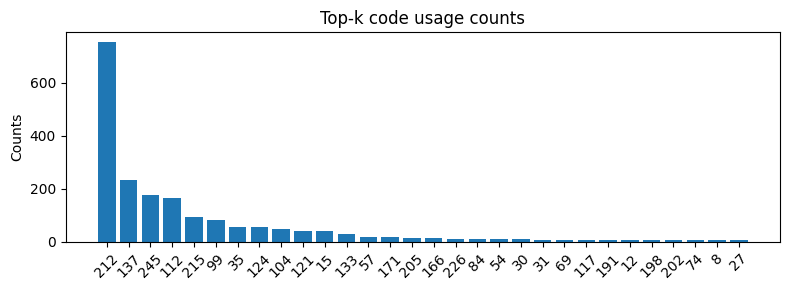

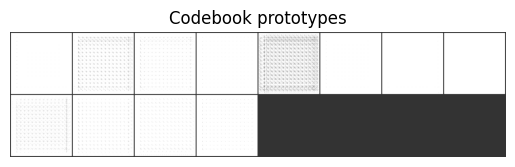

Epoch 65 | G=-0.0696 D=1.0032 R=0.0473 P=0.0000 adv_w=0.393


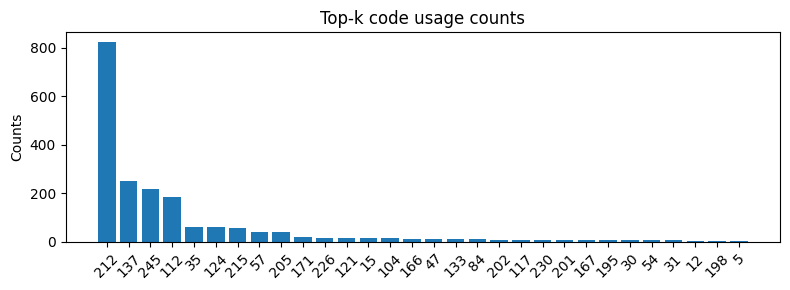

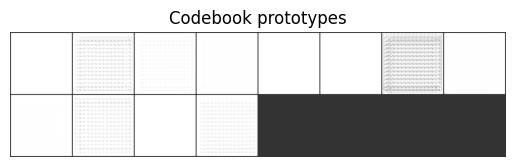

Epoch 66 | G=-0.1051 D=1.0016 R=0.0467 P=0.0000 adv_w=0.400


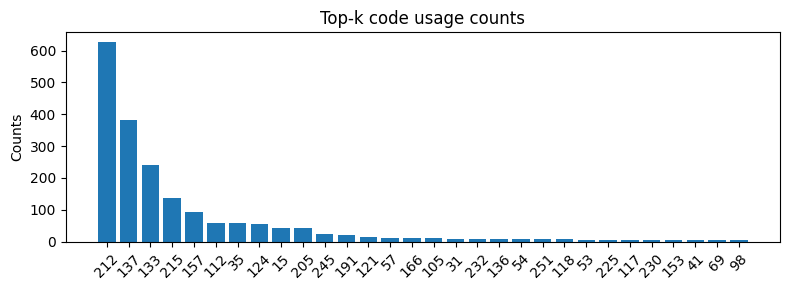

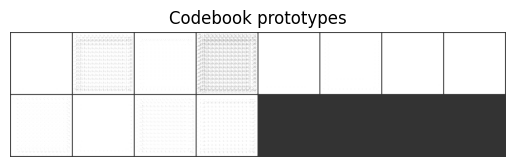

Epoch 67 | G=-0.0756 D=1.0081 R=0.0516 P=0.0000 adv_w=0.407


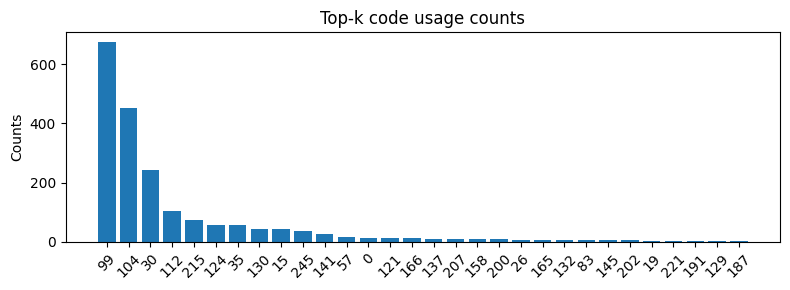

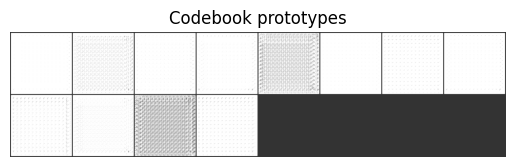

Epoch 68 | G=-0.1043 D=1.0018 R=0.0455 P=0.0000 adv_w=0.414


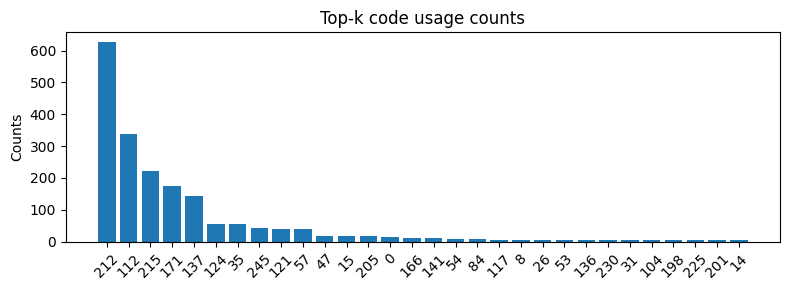

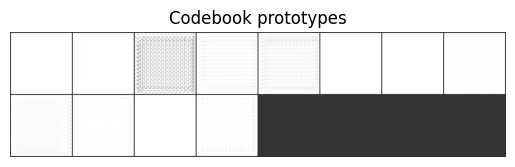

Epoch 69 | G=-0.0500 D=1.0008 R=0.0458 P=0.0000 adv_w=0.421


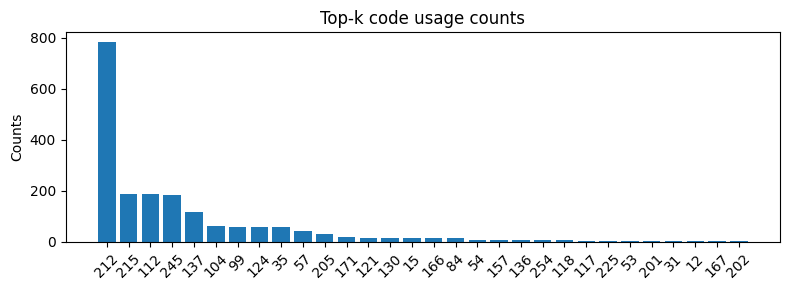

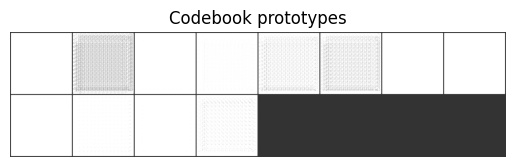

Epoch 70 | G=-0.0776 D=1.0241 R=0.0692 P=0.0000 adv_w=0.429


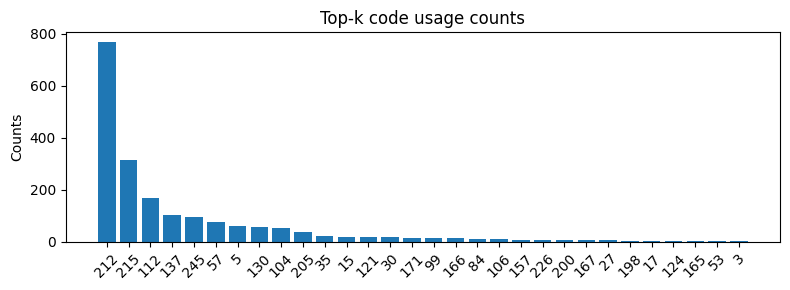

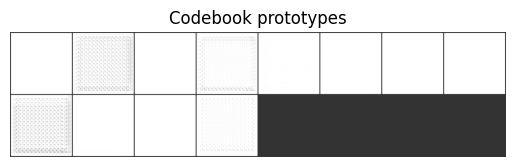

Epoch 71 | G=-0.1037 D=1.0009 R=0.0456 P=0.0000 adv_w=0.436


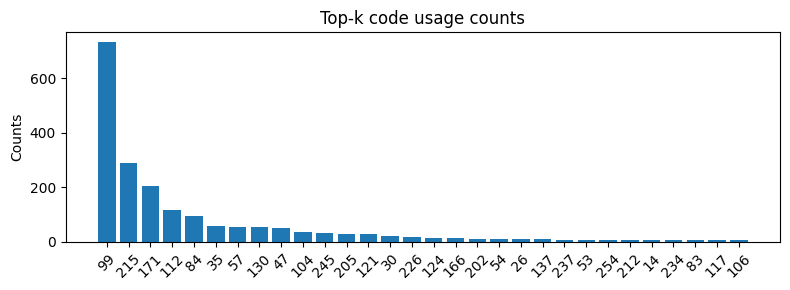

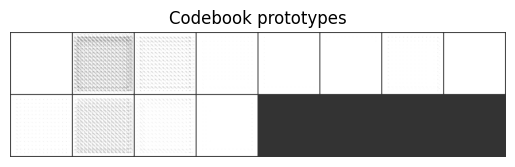

Epoch 72 | G=-0.0700 D=1.0086 R=0.0527 P=0.0000 adv_w=0.443


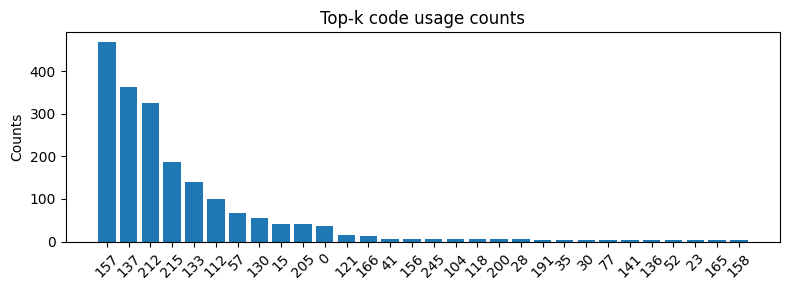

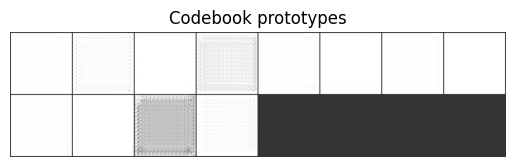

Epoch 73 | G=-0.0428 D=1.0028 R=0.0462 P=0.0000 adv_w=0.450


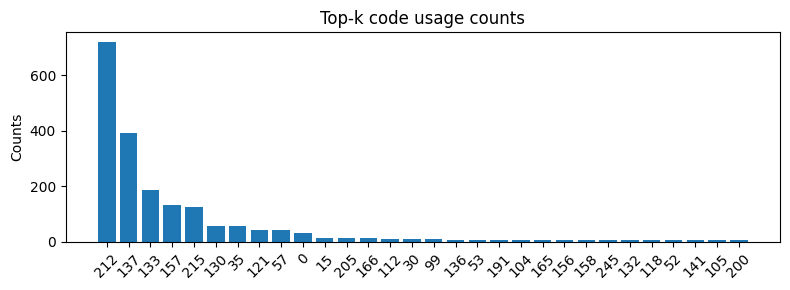

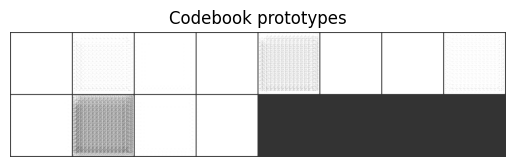

Epoch 74 | G=-0.0285 D=1.0019 R=0.0458 P=0.0000 adv_w=0.457


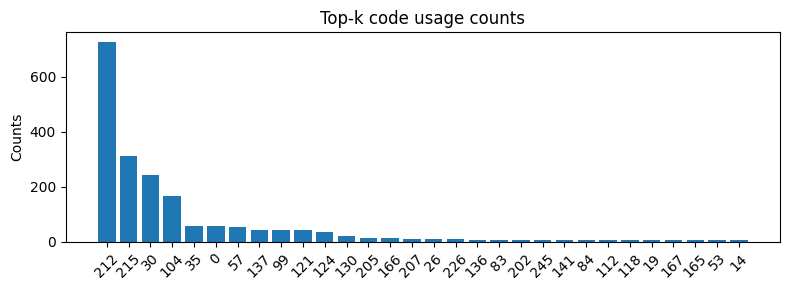

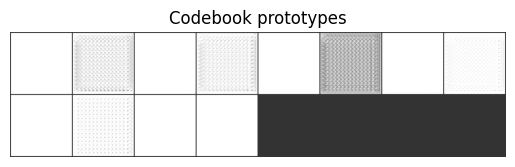

Epoch 75 | G=0.0189 D=1.0016 R=0.0444 P=0.0000 adv_w=0.464


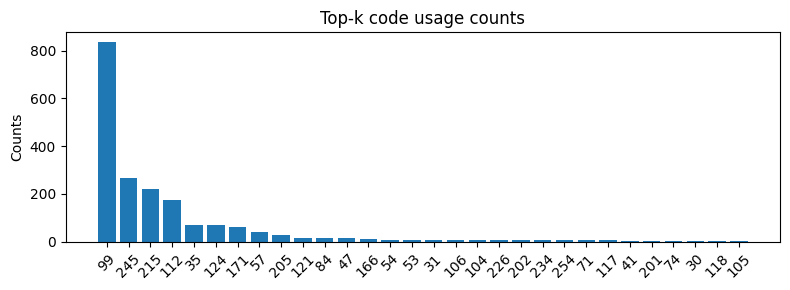

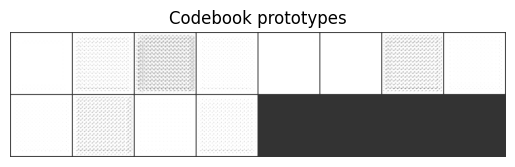

Epoch 76 | G=0.0152 D=1.0064 R=0.0477 P=0.0000 adv_w=0.471


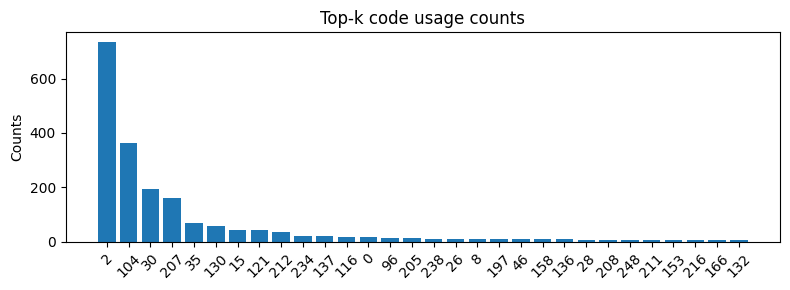

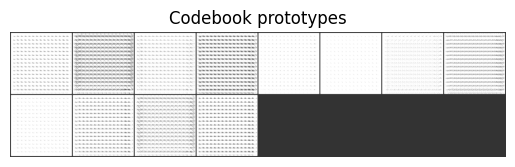

Epoch 77 | G=-0.1059 D=1.0102 R=0.0572 P=0.0000 adv_w=0.479


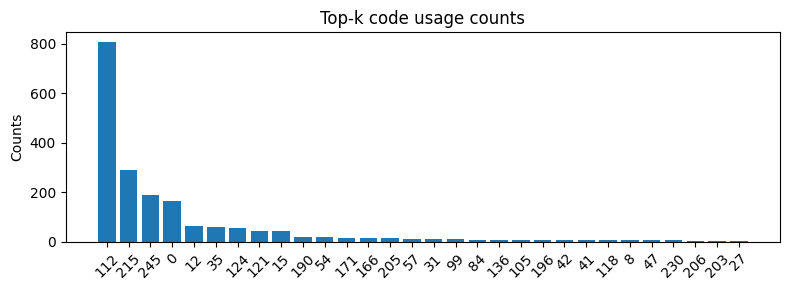

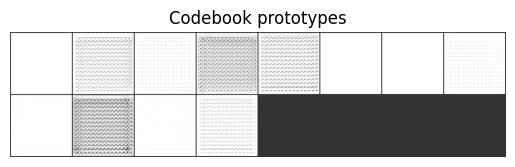

Epoch 78 | G=-0.0892 D=1.0021 R=0.0462 P=0.0000 adv_w=0.486


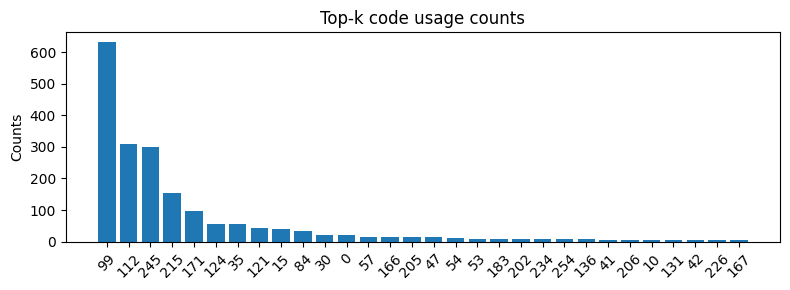

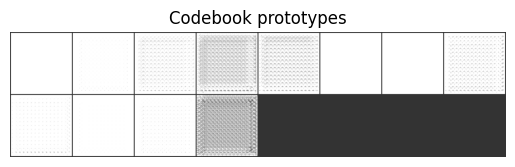

Epoch 79 | G=-0.0683 D=1.0044 R=0.0491 P=0.0000 adv_w=0.493


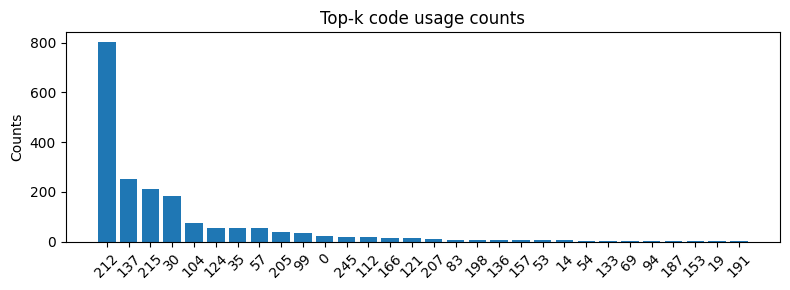

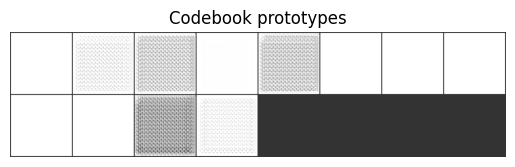

Epoch 80 | G=-0.0668 D=1.0015 R=0.0448 P=0.0000 adv_w=0.500


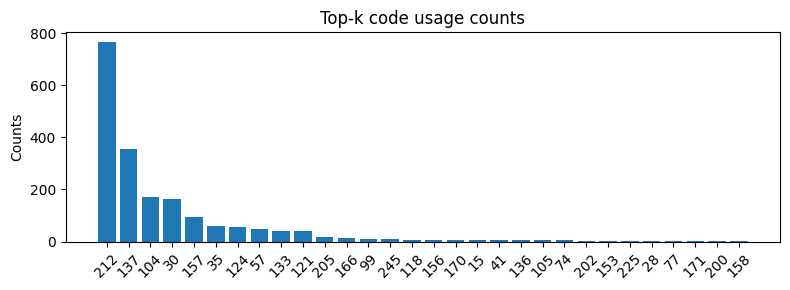

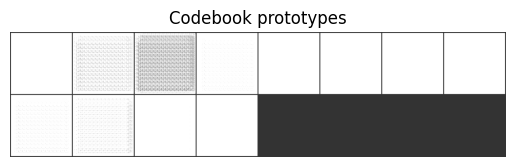

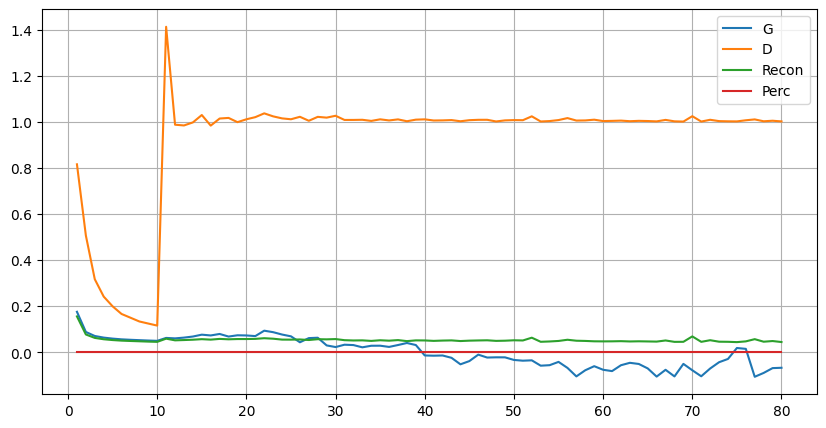

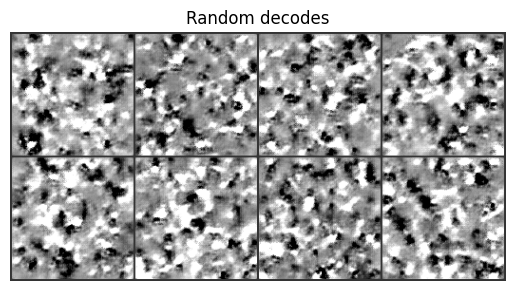

In [ ]:
history = train(train_loader_center_crop, val_loader_center_crop)
plot_loss_curves(history, savepath=os.path.join(HP["SAVE_DIR"], "losses.png"))

# After training, visualize random decodes:
rnd_codes = torch.randint(0, HP["N_CODES"], (8, 16, 16), device=device)
samples = vqgan.decode_from_codes(rnd_codes)
show_batch_tensor_grid(samples, nrow=4, title="Random decodes")